# Clustering & Geodemographics

A common challenge in data analysis is how to group observations in a data set together in a way that allows for generalisation: _this_ group of observations are similar to one another, _that_ group is dissimilar to this group. But what defines similarity and difference? There is no _one_ answer to that question and so there are many different ways to cluster data, each of which has strengths and weaknesses that make them more, or less, appropriate in different contexts.

### Specifying the Kernel

**_Note:_** Before you go any further, we need to check that you've got the right 'Kernel' (virutal environment) specified in Jupyter. Assuming that you are a Year 3 student on our Geocomputation pathway, then at the top right it should say _something_ like "Python \[gsa2018\]" or "GSA2019" (or something very similar to one of those!). There are other kernels configured and these can be accessed by clicking on the 'Kernel' menu item and then 'Change Kernel'. This feature is well beyond the scope of this practical, but it basically allows you to run multiple 'versions' of Python with different libraries or versions of libraries installed at the same time.

If you are not a current student and do not have one of these kernels installed please refer to our [instructions for using Docker or configuring Anaconda Python](https://github.com/kingsgeocomp/gsa_env).

## Getting Organised

#### Ensure Plotting Output

In [1]:
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

#### Importing the Libraries

In [2]:
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import zipfile
import re
import os
import pickle as pk

from sklearn import cluster
from io import BytesIO, StringIO
from os.path import join as pj
from pathlib import Path
from matplotlib.colors import ListedColormap

import sklearn
sklv = int(sklearn.__version__.replace(".",""))
if sklv < 210:
    print("SciKit-Learn verion is: " + sklearn.__version__)
    print("The OPTICS part of this notebook relies on a version >= 0.21.0")

from sklearn.neighbors import NearestNeighbors

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## Clustering in Python

The most commonly-used _aspatial_ clustering algorighms are all found in [scikit-learn](http://scikit-learn.org/stable/), so that will be the focus of this practical. But just as there are aspatial and spatial statistics, there are also _spatially-aware_ clustering algorithms to be found in [PySAL](http://pysal.readthedocs.io/en/latest/), the Python Spatial Analysis Library.

### Clustering in sklearn

One organisation recently produced a handy scikit-learn cheatsheet that you should [download](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf). The terminology used in scikit-learn is rather different from anything you will have encountered before (unless you've studied computer science and, possibly, statistics) so it's worth spending a few minutes mapping what you already know on to the sklearn framework:

|   | **Continuous** | **Categorical** |
| - | ---------- | -----------|
| **Supervised** | Regression | Classification |
| **Unsupervised** | Dimensionality Reduction | Clustering |

So clustering is a form of unsupervised (because we don't train the model on what a 'good' result looks like) and categorical (because we get labels out of the model, not predictors) machine learning. Clustering is often used together with PCA (Principal Components Analysis) which is a form of unsupervised dimensionality reduction: data sets with "high dimensionality" are reduced using PCA (you can think of this as a realignment of the axes with the 'data cloud') which has the effect of _maximising the variance_ on each new axis, and the reduced-dimension dataset is then fed to a clustering algorithm. Similarly, supervised approaches are often paired: logistic regression (supervised) is often used with classification (supervised).

There are a huge number of algorithms provided by sklearn and this 'map' shows only the basic and commonly-used ones:

<a href="http://scikit-learn.org/stable/tutorial/machine_learning_map/"><img alt="SciKit-Learn Algorithm Map" src="http://scikit-learn.org/stable/_static/ml_map.png" width="700px" /></a>

### Which Clustering Approach is Right?

The reason that there is no 'right' approach to clustering is that it all depends on what you're trying to accomplish and how you're _reasoning_ about your problem. The image below highlights the extent to which the different clustering approaches in sklearn can produce different results -- and this is only for the _non-geographic_ algorithms!

<a href="http://scikit-learn.org/stable/modules/clustering.html#clustering"><img alt="Clustering algorithm comparison" src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png" width="700px" /></a>

_Note:_ for geographically-aware clustering you need to look at PySAL.

To think about this in a little more detail:

* If I run an online company and I want to classify my customers on the basis of their product purchases, then I probably don't care much about where they are, only about what they buy, and so my clustering approach doesn't need to take geography into account. I might well _discover_ that many of my most valuable customers live in a few areas, but that is a finding, not a factor, in my research.
* Conversely, if I am looking for cancer clusters then I might well care a _lot_ about geography because I want to make sure that I don't overlook an important cluster of cases because it's 'hidden' inside an area with lots of people who don't have cancer. In that case, I want my clusters to take geography into account. That approach might classify an area with a smaller proportion of cancer patients as part of a 'cancer cluster' but that's because it is still significant _because_ of the geography.

So you can undertake a spatial analysis using _either_ approach, it just depends on the role that you think geography should play in producing the clusters in the first place. We'll see this in action today!

## Obtaining the Data

For the sake of simplicity we're going to work with roughly the same set of data for London that Alexiou & Singleton used in their _Geodemographic Analysis_ chapter from [Geocomputation: A Practical Primer](https://uk.sagepub.com/en-gb/eur/geocomputation/book241023). Although the implementation in the _Primer_ is in the R programming language, the concerns and the approach are exactly the same.

### NomisWeb

Nearly the _entire_ Census is available to download from [InFuse](http://infuse2011.ukdataservice.ac.uk/), but you can often download data 'in bulk' from [NomisWeb](https://www.nomisweb.co.uk/home/detailedstats.asp?resume=no) directly and they also have a (poorly documented) API as well.

The tables we want are:
* KS102EW: Age structure
* KS201EW: Ethnic group
* KS401EW: Dwellings, household space and accommodation type
* KS402EW: Tenure
* KS403EW: Rooms, bedrooms and central heating
* KS404EW: Car or van availability
* KS501EW: Qualifications and students
* KS603EW: Economic Activity by Sex

We want London LSOAs, which you can get by specifying 'Select areas within', then '2011 - super output areas - lower layers', and 'region' (leading to London). 

##### Saving Time

To save you the trouble of manually selecting and downloading each table I have assembled everything into a '[Census.zip](https://github.com/kingsgeocomp/applied_gsa/blob/master/data/Census.zip?raw=true)' file. This will be automatically downloaded into a directory called `analysis` using the code below and you do _not_ need to unzip it.

In [3]:
src = 'https://github.com/kingsgeocomp/applied_gsa/blob/master/data/Census.zip?raw=true'
dst = os.path.join('analysis','Census.zip')

if not os.path.exists(dst):
    if not os.path.exists(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))
    
    print("Downloading...")
    r = requests.get(src, stream=True)
    
    with open(dst, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)
else:
    print("File already downloaded.")
    
print("Done.")

File already downloaded.
Done.


### Loading the NomisWeb Data

You may need to make a few adjustments to the path to get the data loaded on your own computer. But notice what we're now able to do here: using the `zipfile` library we can extract a data file (or any other file) from the Zip archive without even having to open it. Saves even more time _and_ disk space!

In [4]:
z = zipfile.ZipFile(os.path.join('analysis','Census.zip'))
z.namelist()

['148410511-Dwellings.csv',
 '2596417429-Age.csv',
 '2653932334-Ethnicity.csv',
 '2735213988-Rooms.csv',
 '2790216173-Vehicles.csv',
 '2874717391-Tenure.csv',
 '3248615150-Qualifications.csv',
 '99521530-Activity.csv']

We're going to save each data set to a separate data frame to make it easier to work with during cleaning. But note that this code is fairly flexible since we stick each new dataframe in a dictionary (`d`) where we can retrieve them via an iterator.

In [29]:
d = {}
total_cols = 0

for r in range(0, len(z.namelist())):
    
    m  = re.search("(?:-)([^\.]+)", z.namelist()[r])
    nm = m.group(1)
    
    print("Processing {0} file: ".format(nm))
    
    with z.open(z.namelist()[r]) as f:
                
        if z.namelist()[r] == '99521530-Activity.csv': 
            d[nm] = pd.read_csv(BytesIO(f.read()), header=7, skip_blank_lines=True, skipfooter=7, engine='python')
        else:
            d[nm] = pd.read_csv(BytesIO(f.read()), header=6, skip_blank_lines=True, skipfooter=7, engine='python')
    
    print("\tShape of dataframe is {0} rows by {1} columns".format(d[nm].shape[0], d[nm].shape[1]))
    total_cols += d[nm].shape[1]

print("There are {0} columns in all.".format(total_cols))

Processing Dwellings file: 
	Shape of dataframe is 4835 rows by 14 columns
Processing Age file: 
	Shape of dataframe is 4835 rows by 19 columns
Processing Ethnicity file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Rooms file: 
	Shape of dataframe is 4835 rows by 10 columns
Processing Vehicles file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Tenure file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Qualifications file: 
	Shape of dataframe is 4835 rows by 10 columns
Processing Activity file: 
	Shape of dataframe is 4835 rows by 11 columns
There are 88 columns in all.


### ONS Boundary Data

We also need to download the LSOA boundary data. A quick Google search on "2011 LSOA boundaries" will lead you to the [Data.gov.uk portal](https://data.gov.uk/dataset/lower_layer_super_output_area_lsoa_boundaries). The rest is fairly straightforward:
* We want 'generalised' because that means that they've removed some of the detail from the boundaries so the file will load (and render) more quickly.
* We want 'clipped' because that means that the boundaries have been clipped to the edges of the land (e.g. the Thames; the 'Full' data set splits the Thames down the middle between adjacent LSOAs).

#### Saving Time

Again, in order to get you started more quickly I've already created a 'pack' for you. However, note that the format of this is a GeoPackage, this is a fairly new file format designed to replace ESRI's antique Shapefile format, and it allows us to include all kinds of useful information as part of the download as well as doing away with the need to unzip a download first! So here we load the data directly into a geopandas dataframe:

In [364]:
src = 'https://github.com/kingsgeocomp/applied_gsa/raw/master/data/London%20LSOAs.gpkg'

gdf = gpd.read_file(src)
print("Shape of LSOA file: {0} rows by {1} columns".format(gdf.shape[0], gdf.shape[1]))
gdf.columns = [x.lower() for x in gdf.columns.values]
gdf.set_index('lsoa11cd', drop=True, inplace=True)
gdf.sample(4)

Shape of LSOA file: 4835 rows by 4 columns


lsoa11nm                  lsoa11nmw  \
lsoa11cd                                                          
E01004525            Wandsworth 035A            Wandsworth 035A   
E01002989  Kingston upon Thames 011D  Kingston upon Thames 011D   
E01001156               Croydon 001C               Croydon 001C   
E01004017             Southwark 029C             Southwark 029C   

                                                    geometry  
lsoa11cd                                                      
E01004525  (POLYGON ((527576.6400000703 171673.34, 527657...  
E01002989  (POLYGON ((517821.7310000717 167552.1169998408...  
E01001156  (POLYGON ((532938.7070001635 170531.0260000801...  
E01004017  (POLYGON ((535334.0000000823 174461.0000000615...

#### <span style="color:red">Error!</span>

Depending on your version of GDAL/Fiona, you may not be able to read the GeoPackage file directly. In this case you will need to replace the code above with the code below for downloading and extracting a Shapefile from a Zip archive:
```python
src = 'https://github.com/kingsgeocomp/applied_gsa/blob/master/data/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.zip?raw=true'
dst = os.path.join('analysis','LSOAs.zip')
zpd = 'analysis'

if not os.path.exists(dst):
    if not os.path.exists(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))

    r = requests.get(src, stream=True)

    with open(dst, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

if not os.path.exists(zpd):
    os.makedirs(os.path.dirname(zpd))
    
zp = zipfile.ZipFile(dst, 'r')
zp.extractall(zpd)
zp.close()

gdf = gpd.read_file(os.path.join('analysis','lsoas','Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp'))
gdf.crs = {'init' :'epsg:27700'}
print(\"Shape of LSOA file: {0} rows by {1} columns\".format(gdf.shape[0], gdf.shape[1]))
gdf.set_index('lsoa11cd', drop=True, inplace=True)
gdf.sample(4)
```

You can probably see why I'm a big fan of GeoPackages when they're available!

### Other Sources of Data

If you're more interested in US Census data then there's a nice-looking (though I haven't used it) [wrapper to the Census API](https://pypi.python.org/pypi/census). And [Spielman and Singleton](https://www.tandfonline.com/doi/full/10.1080/00045608.2015.1052335) have done some work on large-scale geodemographic clustering of U.S. Census geographies.

## Tidying Up

So we have 4,835 rows and 88 columns. However, we don't know how many of those columns are redundant and so need to work out what might need removing from the data set before we can try clustering. So we're going to work our way through each data set in turn so that we can convert them to percentages before combining them into a single, large data set.

#### Brief Discussion

In the practical I've followed the _Geocomputation_ approach of basically converting everything to percentages and then clustering on that. This is _one_ way to approach this problem, but there are _many_ others. For instance, I'd probably approach this by skipping the percentages part and applying robust rescaling ([`sklearn.preprocessing.RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)) using centering and quantile standardisation (the 2.5th and 97.5th, for example) instead. I would then consider using PCA on groups of related variables (_e.g._ the housing features as a group, the ethnicity features as a group, etc.) and then take the first few eigenvalues from each group and cluster on all of those together. This would remove quite a bit of the correlation between variables and still allow us to perform hierarchical and other types of clustering on the result. It would also do a better job of preserving outliers.

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Reflect on why there are different ways to prepare data for clustering and how thes approaches above (Google if you have to!) might produce different results.</div>

### Dwellings

From dewllings we're mainly interested in the housing type since we would expect that housing typologies will be a determinant of the types of people who live in an area. We _could_ look at places with no usual residents as well, or explore the distribution of shared dwellings, but this is a pretty good start.

In [30]:
t = 'Dwellings'
d[t].columns

Index(['2011 super output area - lower layer', 'mnemonic', 'Unshared dwelling',
       'Shared dwelling: Two household spaces',
       'Shared dwelling: Three or more household spaces',
       'Household spaces with at least one usual resident',
       'Household spaces with no usual residents',
       'Whole house or bungalow: Detached',
       'Whole house or bungalow: Semi-detached',
       'Whole house or bungalow: Terraced (including end-terrace)',
       'Flat, maisonette or apartment: Purpose-built block of flats or tenement',
       'Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)',
       'Flat, maisonette or apartment: In a commercial building',
       'Caravan or other mobile or temporary structure'],
      dtype='object')

In [32]:
# Select the columns we're interested in analysing
selection = [
    'mnemonic',
    'Whole house or bungalow: Detached', 
    'Whole house or bungalow: Semi-detached',
    'Whole house or bungalow: Terraced (including end-terrace)',
    'Flat, maisonette or apartment: Purpose-built block of flats or tenement',
    'Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)',
    'Flat, maisonette or apartment: In a commercial building']

# Drop everything *not* in the selection
d[t].drop(d[t].columns[~np.isin(d[t].columns.values,selection)].values, axis=1, inplace=True)

# Recalculate the Total Properties based on the
# new set of fields (these often don't match up 100%)
d[t]['Total Properties'] = d[t].loc[:, selection].sum(axis=1)

d[t].sample(5, random_state=42)

mnemonic  Whole house or bungalow: Detached  \
3317  E01001500                                 26   
2533  E01000551                                 10   
1041  E01003220                                 13   
3307  E01001534                                 37   
4401  E01003791                                 29   

      Whole house or bungalow: Semi-detached  \
3317                                      89   
2533                                      10   
1041                                      60   
3307                                     325   
4401                                     252   

      Whole house or bungalow: Terraced (including end-terrace)  \
3317                                                329           
2533                                                 29           
1041                                                263           
3307                                                106           
4401                                                188           

      Flat, maisonette or apartment: Purpose-built block of flats or tenement  \
3317                                                 44                         
2533                                                807                         
1041                                                 53                         
3307                                                 91                         
4401                                                 64                         

      Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)  \
3317                                                 71                                         
2533                                                 85                                         
1041                                                219                                         
3307                                                 17                                         
4401                                                 19                                         

      Flat, maisonette or apartment: In a commercial building  \
3317                                                  3         
2533                                                  6         
1041                                                  5         
3307                                                 23         
4401                                                  0         

      Total Properties  
3317               562  
2533               947  
1041               613  
3307               599  
4401               552

In [37]:
# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection[1:]:
    m  = re.search("^(?:[^\:]*)(?:\:\s)?([^\(]+)", c)
    nm = m.group(1).strip()
    print("Renaming '{0}' to '{1}'".format(c, nm))
    d_pct[nm] = pd.Series(d[t][c].astype(float)/d[t]['Total Properties'].astype(float))

Renaming 'Whole house or bungalow: Detached' to 'Detached'
Renaming 'Whole house or bungalow: Semi-detached' to 'Semi-detached'
Renaming 'Whole house or bungalow: Terraced (including end-terrace)' to 'Terraced'
Renaming 'Flat, maisonette or apartment: Purpose-built block of flats or tenement' to 'Purpose-built block of flats or tenement'
Renaming 'Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)' to 'Part of a converted or shared house'
Renaming 'Flat, maisonette or apartment: In a commercial building' to 'In a commercial building'


In [38]:
d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5, random_state=42)

mnemonic  Detached  Semi-detached  Terraced  \
3317  E01001500      0.05           0.16      0.59   
2533  E01000551      0.01           0.01      0.03   
1041  E01003220      0.02           0.10      0.43   
3307  E01001534      0.06           0.54      0.18   
4401  E01003791      0.05           0.46      0.34   

      Purpose-built block of flats or tenement  \
3317                                      0.08   
2533                                      0.85   
1041                                      0.09   
3307                                      0.15   
4401                                      0.12   

      Part of a converted or shared house  In a commercial building  
3317                                 0.13                      0.01  
2533                                 0.09                      0.01  
1041                                 0.36                      0.01  
3307                                 0.03                      0.04  
4401                                 0.03                      0.00

### Age

Clearly, some areas have more young people, some have older people, and some will be composed of families. A lot of these are going to be tied to 'lifestage' and so will help us to understand something about the types of areas in which they live.

In [39]:
t = 'Age'
d[t].columns

Index(['2011 super output area - lower layer', 'mnemonic',
       'All usual residents', 'Age 0 to 4', 'Age 5 to 7', 'Age 8 to 9',
       'Age 10 to 14', 'Age 15', 'Age 16 to 17', 'Age 18 to 19',
       'Age 20 to 24', 'Age 25 to 29', 'Age 30 to 44', 'Age 45 to 59',
       'Age 60 to 64', 'Age 65 to 74', 'Age 75 to 84', 'Age 85 to 89',
       'Age 90 and over'],
      dtype='object')

In [40]:
# Derived columns
d[t]['Age 0 to 14']  = d[t]['Age 0 to 4'] + d[t]['Age 5 to 7'] + d[t]['Age 8 to 9'] + d[t]['Age 10 to 14'] 
d[t]['Age 15 to 24'] = d[t]['Age 15'] + d[t]['Age 16 to 17'] + d[t]['Age 18 to 19'] + d[t]['Age 20 to 24']
d[t]['Age 25 to 44'] = d[t]['Age 25 to 29'] + d[t]['Age 30 to 44']
d[t]['Age 45 to 64'] = d[t]['Age 45 to 59'] + d[t]['Age 60 to 64']
d[t]['Age 65+'] = d[t]['Age 65 to 74'] + d[t]['Age 75 to 84'] + d[t]['Age 85 to 89'] + d[t]['Age 90 and over']

# Select the columns we're interested in analysing
selection = ['Age 0 to 14','Age 15 to 24',
             'Age 25 to 44','Age 45 to 64','Age 65+']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the selection of columns
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5, random_state=42)

mnemonic  Age 0 to 14  Age 15 to 24  Age 25 to 44  Age 45 to 64  \
3317  E01001500         0.19          0.13          0.31          0.24   
2533  E01000551         0.26          0.13          0.34          0.19   
1041  E01003220         0.17          0.15          0.33          0.23   
3307  E01001534         0.16          0.12          0.32          0.23   
4401  E01003791         0.17          0.11          0.24          0.32   

      Age 65+  
3317     0.13  
2533     0.08  
1041     0.12  
3307     0.17  
4401     0.16

### Ethnicity

We might also think that the balance of ethnic groups might impact a categorisation of LSOAs in London.

In [42]:
t = 'Ethnicity'
d[t].columns

Index(['2011 super output area - lower layer', 'mnemonic',
       'All usual residents', 'White', 'Mixed/multiple ethnic groups',
       'Asian/Asian British', 'Black/African/Caribbean/Black British',
       'Other ethnic group'],
      dtype='object')

In [43]:
# Select the columns we're interested in analysing
selection = ['White', 'Mixed/multiple ethnic groups', 'Asian/Asian British', 
             'Black/African/Caribbean/Black British', 'Other ethnic group']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5, random_state=42)

mnemonic  White  Mixed/multiple ethnic groups  Asian/Asian British  \
3317  E01001500   0.65                          0.06                 0.13   
2533  E01000551   0.29                          0.08                 0.11   
1041  E01003220   0.47                          0.08                 0.07   
3307  E01001534   0.62                          0.04                 0.23   
4401  E01003791   0.74                          0.05                 0.14   

      Black/African/Caribbean/Black British  Other ethnic group  
3317                                   0.08                0.08  
2533                                   0.44                0.09  
1041                                   0.33                0.05  
3307                                   0.07                0.05  
4401                                   0.06                0.02

### Rooms

Let's next incorporate the amount of space available to each household.

In [44]:
t = 'Rooms'
d[t].columns

Index(['2011 super output area - lower layer', 'mnemonic',
       'All categories: Type of central heating in household',
       'Does not have central heating', 'Does have central heating',
       'Occupancy rating (rooms) of -1 or less',
       'Occupancy rating (bedrooms) of -1 or less', 'Average household size',
       'Average number of rooms per household',
       'Average number of bedrooms per household'],
      dtype='object')

In [45]:
# Select the columns we're interested in analysing
selection = ['Occupancy rating (bedrooms) of -1 or less', 
             'Average household size', 
             'Average number of bedrooms per household']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5, random_state=42)

mnemonic  Occupancy rating (bedrooms) of -1 or less  \
3317  E01001500                                      70.00   
2533  E01000551                                     179.00   
1041  E01003220                                      62.00   
3307  E01001534                                      47.00   
4401  E01003791                                      16.00   

      Average household size  Average number of bedrooms per household  
3317                    2.70                                      2.70  
2533                    2.30                                      1.90  
1041                    2.50                                      2.60  
3307                    2.70                                      3.00  
4401                    2.80                                      3.60

### Vehicles

Car ownership and use is also known to be a good predictor of social and economic 'status': Guy Lansley's article on the DLVA's registration database offers a useful perpective on the usefulness of this approach.

In [49]:
t = 'Vehicles'
d[t].columns

Index(['2011 super output area - lower layer', 'mnemonic',
       'All categories: Car or van availability',
       'No cars or vans in household', '1 car or van in household',
       '2 cars or vans in household', '3 cars or vans in household',
       '4 or more cars or vans in household'],
      dtype='object')

In [51]:
# Select the columns we're interested in analysing
selection = [
    'No cars or vans in household', 
    '1 car or van in household',
    '2 cars or vans in household', 
    '3 or more cars or vans in household']

# Calculate a new column
d[t]['3 or more cars or vans in household'] = d[t]['3 cars or vans in household'] + d[t]['4 or more cars or vans in household']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Car or van availability'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5, random_state=42)

mnemonic  No cars or vans in household  1 car or van in household  \
3317  E01001500                          0.29                       0.45   
2533  E01000551                          0.67                       0.28   
1041  E01003220                          0.43                       0.42   
3307  E01001534                          0.24                       0.45   
4401  E01003791                          0.15                       0.44   

      2 cars or vans in household  3 or more cars or vans in household  
3317                         0.20                                 0.05  
2533                         0.04                                 0.00  
1041                         0.12                                 0.03  
3307                         0.24                                 0.07  
4401                         0.32                                 0.10

### Tenure

Ownership structure is another categorisation predictor.

In [52]:
t = 'Tenure'
d[t].columns

Index(['2011 super output area - lower layer', 'mnemonic', 'All households',
       'Owned', 'Shared ownership (part owned and part rented)',
       'Social rented', 'Private rented', 'Living rent free'],
      dtype='object')

In [54]:
# Select the columns we're interested in analysing
selection = [
    'Owned', 
    'Social rented', 
    'Private rented']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All households'].astype(float))

# These will not add up to 100% because we've dropped
# two tenure types with low incidences
d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5, random_state=42)

mnemonic  Owned  Social rented  Private rented
3317  E01001500   0.67           0.05            0.27
2533  E01000551   0.10           0.79            0.09
1041  E01003220   0.56           0.18            0.25
3307  E01001534   0.70           0.03            0.24
4401  E01003791   0.88           0.03            0.08

### Qualifications

You can find out a bit more about qualifications [here](https://www.surreyi.gov.uk/2011-census/highest-level-of-qualification/#header-qualifications-categories).

In [55]:
t = 'Qualifications'
d[t].columns

Index(['2011 super output area - lower layer', 'mnemonic',
       'All categories: Highest level of qualification', 'No qualifications',
       'Highest level of qualification: Level 1 qualifications',
       'Highest level of qualification: Level 2 qualifications',
       'Highest level of qualification: Apprenticeship',
       'Highest level of qualification: Level 3 qualifications',
       'Highest level of qualification: Level 4 qualifications and above',
       'Highest level of qualification: Other qualifications'],
      dtype='object')

In [59]:
# Select the columns we're interested in analysing
selection = [
    'Highest level of qualification: Below Level 3 qualifications',
    'Highest level of qualification: Level 3 qualifications',
    'Highest level of qualification: Level 4 qualifications and above',
    'Highest level of qualification: Other qualifications']

# Derive a new aggregate field for 'didn't complete HS'
d[t]['Highest level of qualification: Below Level 3 qualifications'] = \
    d[t]['No qualifications'] + \
    d[t]['Highest level of qualification: Level 1 qualifications'] + \
    d[t]['Highest level of qualification: Level 2 qualifications'] + \
    d[t]['Highest level of qualification: Apprenticeship'] 

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    m  = re.search("^(?:[^\:]*)(?:\:\s)?([^\(]+)", c)
    nm = m.group(1).strip()
    print("Renaming '{0}' to '{1}'".format(c, nm))
    d_pct[nm] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Highest level of qualification'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5, random_state=42)

Renaming 'Highest level of qualification: Below Level 3 qualifications' to 'Below Level 3 qualifications'
Renaming 'Highest level of qualification: Level 3 qualifications' to 'Level 3 qualifications'
Renaming 'Highest level of qualification: Level 4 qualifications and above' to 'Level 4 qualifications and above'
Renaming 'Highest level of qualification: Other qualifications' to 'Other qualifications'


mnemonic  Below Level 3 qualifications  Level 3 qualifications  \
3317  E01001500                          0.44                    0.10   
2533  E01000551                          0.54                    0.09   
1041  E01003220                          0.45                    0.11   
3307  E01001534                          0.39                    0.10   
4401  E01003791                          0.37                    0.11   

      Level 4 qualifications and above  Other qualifications  
3317                              0.32                  0.14  
2533                              0.24                  0.12  
1041                              0.36                  0.08  
3307                              0.40                  0.11  
4401                              0.45                  0.07

### Activity

In [60]:
t = 'Activity'
d[t].columns

Index(['2011 super output area - lower layer', 'mnemonic',
       'All usual residents aged 16 to 74',
       'Economically active: In employment', 'Economically active: Unemployed',
       'Economically active: Full-time student',
       'Economically inactive: Retired',
       'Economically inactive: Student (including full-time students)',
       'Economically inactive: Looking after home or family',
       'Economically inactive: Long-term sick or disabled',
       'Economically inactive: Other'],
      dtype='object')

In [61]:
# Select the columns we're interested in analysing
selection = [
    'Economically active: In employment',
    'Economically active: Unemployed',
    'Economically active: Full-time student',
    'Economically inactive: Retired',
    'Economically inactive: Looking after home or family',
    'Economically inactive: Long-term sick or disabled',
    'Economically inactive: Other']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    m = re.search("^Eco.*?active: (.+)$", c)
    nm = m.group(1)
    d_pct[nm] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents aged 16 to 74'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5, random_state=42)

mnemonic  In employment  Unemployed  Full-time student  Retired  \
3317  E01001500           0.62        0.04               0.04     0.12   
2533  E01000551           0.51        0.12               0.05     0.07   
1041  E01003220           0.63        0.06               0.05     0.08   
3307  E01001534           0.63        0.03               0.04     0.11   
4401  E01003791           0.68        0.04               0.02     0.14   

      Looking after home or family  Long-term sick or disabled  Other  
3317                          0.05                        0.04   0.02  
2533                          0.06                        0.07   0.04  
1041                          0.04                        0.05   0.03  
3307                          0.05                        0.03   0.02  
4401                          0.04                        0.02   0.02

### Creating the Single Data Set

Now that we've converted everything to percentages, it's time to bring the data together! We'll initialise the data frame using the first matching data set, and then iterate over the rest, merging the data frames as we go.

In [63]:
matching = [s for s in d.keys() if "_pct" in s]
print("Found the following standardised data frames:\n\t" + ", ".join(matching))

lsoac = d[matching[0]]

for m in range(1, len(matching)):
    lsoac = lsoac.merge(d[matching[m]], how='inner', left_on='mnemonic', right_on='mnemonic')

Found the following standardised data frames:
	Dwellings_pct, Age_pct, Ethnicity_pct, Rooms_pct, Vehicles_pct, Tenure_pct, Qualifications_pct, Activity_pct


In [64]:
# Change the index
lsoac.set_index('mnemonic', drop=True, inplace=True)
lsoac.index.name = None

In [65]:
print(lsoac.columns.values)

['Detached' 'Semi-detached' 'Terraced'
 'Purpose-built block of flats or tenement'
 'Part of a converted or shared house' 'In a commercial building'
 'Age 0 to 14' 'Age 15 to 24' 'Age 25 to 44' 'Age 45 to 64' 'Age 65+'
 'White' 'Mixed/multiple ethnic groups' 'Asian/Asian British'
 'Black/African/Caribbean/Black British' 'Other ethnic group'
 'Occupancy rating (bedrooms) of -1 or less' 'Average household size'
 'Average number of bedrooms per household' 'No cars or vans in household'
 '1 car or van in household' '2 cars or vans in household'
 '3 or more cars or vans in household' 'Owned' 'Social rented'
 'Private rented' 'Below Level 3 qualifications' 'Level 3 qualifications'
 'Level 4 qualifications and above' 'Other qualifications' 'In employment'
 'Unemployed' 'Full-time student' 'Retired' 'Looking after home or family'
 'Long-term sick or disabled' 'Other']


In [66]:
print("Shape of full data frame is {0} by {1}".format(lsoac.shape[0], lsoac.shape[1]))

Shape of full data frame is 4835 by 37


With luck you still have 4,835 rows, but now you have 'just' 37 columns.

## Removing Badly-Behaved Features

### Start with a Chart!
Generally, a 'well-behaved' feature (_i.e._ column) is one which doesn't skew too heavily or have extreme outliers. One way to check this is manually by looking at the data distributions for each feature. Note that here we dump the charts that we output into a directory called `outputs` and a subdirectory called `distributions`:

In [69]:
o_dir = os.path.join('outputs','distributions')
if os.path.isdir(o_dir) is not True:
    print("Creating '{0}' directory for images.".format(o_dir))
    os.mkdir(o_dir)

Creating 'outputs/distributions' directory for images.


In [70]:
col_pos=0
for c in lsoac.columns.values:
    print("Creating chart for " + c + " ({:02d})".format(col_pos))
    nm = c.replace("/", "-")
    fig, ax = plt.subplots()
    fig.set_size_inches(7,4)
    sns.distplot(lsoac[c])
    fig.savefig(os.path.join(o_dir, "{:02d}".format(col_pos) + "-" + nm + '.png'))
    plt.close(fig)
    col_pos += 1

Creating chart for Detached (00)
Creating chart for Semi-detached (01)
Creating chart for Terraced (02)
Creating chart for Purpose-built block of flats or tenement (03)
Creating chart for Part of a converted or shared house (04)
Creating chart for In a commercial building (05)
Creating chart for Age 0 to 14 (06)
Creating chart for Age 15 to 24 (07)
Creating chart for Age 25 to 44 (08)
Creating chart for Age 45 to 64 (09)
Creating chart for Age 65+ (10)
Creating chart for White (11)
Creating chart for Mixed/multiple ethnic groups (12)
Creating chart for Asian/Asian British (13)
Creating chart for Black/African/Caribbean/Black British (14)
Creating chart for Other ethnic group (15)
Creating chart for Occupancy rating (bedrooms) of -1 or less (16)
Creating chart for Average household size (17)
Creating chart for Average number of bedrooms per household (18)
Creating chart for No cars or vans in household (19)
Creating chart for 1 car or van in household (20)
Creating chart for 2 cars or v

You can review these figures individually to confirm any intuition that you might have regarding their utility, but we can also do this in a slightly less subtle (but more reproducible and automatable way) but simply calculating the skew on every column in the data set and showing this on a plot:

Text(0.5, 1.0, 'Skew by Variable for Shares Data')

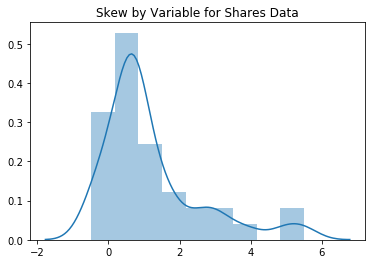

In [71]:
sns.distplot(lsoac.skew(axis=0, numeric_only=True).values).set_title("Skew by Variable for Shares Data")

Lower skew values are generally better for clustering and, as a baseline data with skews greater than +/-1 are often considered highly skewed. We could be a little more flexible and go with, say, 2.5 but this still gives us a problem:

In [94]:
sk = lsoac.skew(axis=0, numeric_only=True)
to_drop = sk[abs(sk) > 1.5].index
print(to_drop)

Index(['Detached', 'Part of a converted or shared house',
       'In a commercial building', 'Age 15 to 24', 'Asian/Asian British',
       'Other ethnic group', '3 or more cars or vans in household',
       'Level 3 qualifications', 'Full-time student', 'Other'],
      dtype='object')


Rather than crudely drop variables based on skew we're going to try to normalise the data instead and then check back to see if this has reduced skew in the data set in a useful way. But before we do that let's save our data frame.

In [74]:
# The pickle is a 'live' Python class written to 
# disk -- so it's easy to re-load the data and get 
# moving again. In other words, if you change your
# mind about anything you've done later, you can just
# re-start your analysis from the next code block
lsoac.to_pickle(os.path.join('data','LSOAC.pickle'))
del(lsoac)

### Normalisation

The _Geocomputation_ handbook suggests that normalisation via log or Box-Cox transformation happens _after_ the variables have been converted to percentages, so that's what I've done here. I think that this approach is debatable as it's potentially harder to deal with zeroes in the data _after_ converting to a percentage than it was before. The reason that zeroes are an issue is that the log of 0.0 is `-Inf` or `NaN`, so this blows up in your cluster analysis if you don't deal with it now. The easiest way to do this is to simply add `1` to every raw count, ensuring that the smallest value in your data set is always positive. If you had already converted to a percentage then adding 0.000001% to only the zero values still changes the actual distribution, while adding 0.000001% to all values could leave you with percentages over 100!

In [93]:
lsoac = pd.read_pickle(os.path.join('data','LSOAC.pickle'))
numeric_cols = [col for col in lsoac if lsoac[col].dtype.kind != 'O']
lsoac[numeric_cols] += 1

In [95]:
from scipy.stats import boxcox

o_dir = os.path.join('outputs','transformed')
if os.path.isdir(o_dir) is not True:
    print("Creating '{0}' directory for images.".format(o_dir))
    os.mkdir(o_dir)
    
col_pos = 0
for c in lsoac.columns:
    if lsoac[c].dtype.kind != 'O':
        if abs(lsoac[c].skew()) > 1.5:
            if lsoac[c].min() < 0:
                print("Should transform {0} but it has negative numbers!")
            else:
                print("Transforming " + c)
                x, _ = boxcox( lsoac[c] )
                lsoac[c] = pd.Series(x, index=lsoac.index)
                
                nm = c.replace("/", "-")
                fig, ax = plt.subplots()
                fig.set_size_inches(7,4)
                sns.distplot(x, hist=True)
                fig.savefig(os.path.join(o_dir, "{:02d}".format(col_pos) + "-Box-Cox-" + nm + '.png'))
                plt.close(fig)
        col_pos += 1
        

Transforming Detached
Transforming Part of a converted or shared house
Transforming In a commercial building
Transforming Age 15 to 24
Transforming Asian/Asian British
Transforming Other ethnic group
Transforming 3 or more cars or vans in household
Transforming Level 3 qualifications
Transforming Full-time student
Transforming Other


<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Make sure that you understand what the code you just did has achieved.</div>

You can now see that all of the variables have modest skew.

Index([], dtype='object')


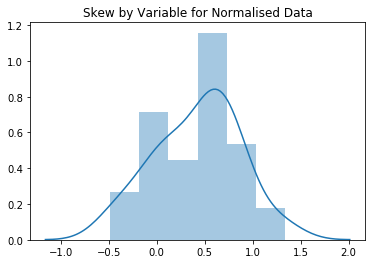

In [96]:
sns.distplot(lsoac.skew(axis=0, numeric_only=True).values).set_title("Skew by Variable for Normalised Data")
sk = lsoac.skew(axis=0, numeric_only=True)
to_drop = sk[sk >= 1.5].index
print(to_drop)

### Further Standardising the Data?

One of the main challenges of clustering, however, is that the scale of each dimension matters: if you were to try to cluster, for example, [1] how many metres per year a glacier moved with [2] the number of cubic metres by which it grew, then you would only be clustering on variable [2]. That's because glaciers contain millions of cubic metres of ice and will grow or shrink by thousands of cubic metres each year. In contrast, most glaciers move at most a few metres per year. So the sheer scale difference between these two dimensions means that the values of variable 1 dominate the clustering algorithm because they provide a much better 'spread' in the data than variable 2.

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Make sure that you understand why the units of a dimension matter to the clustering results.</div>

Converting to percentages/proportions is already a form of standardisation, but recall that some variables (while no longer skewed) had very different distributional ranges from other variables and we would probably prefer scales are relatively consistent. This is one reason that I might have prefered to perform robust rescaling _instead_ rather than getting to this point and wondering if I should apply a _second_ transformation!

So there's no _one_ way to standardise the data, it depends on the characteristics of the data _as well as_ what we're looking for in terms of clustering. As a general rule, we're _aiming_ for a normal (a.k.a. Gaussian) distribution with 0 mean and unit variance. The latter part of this is what most people focus on: you may recall our work with transformations last year, and here's one more reason why it's useful. 

Let's start by just looking at a few variables in a simple scatter plot...

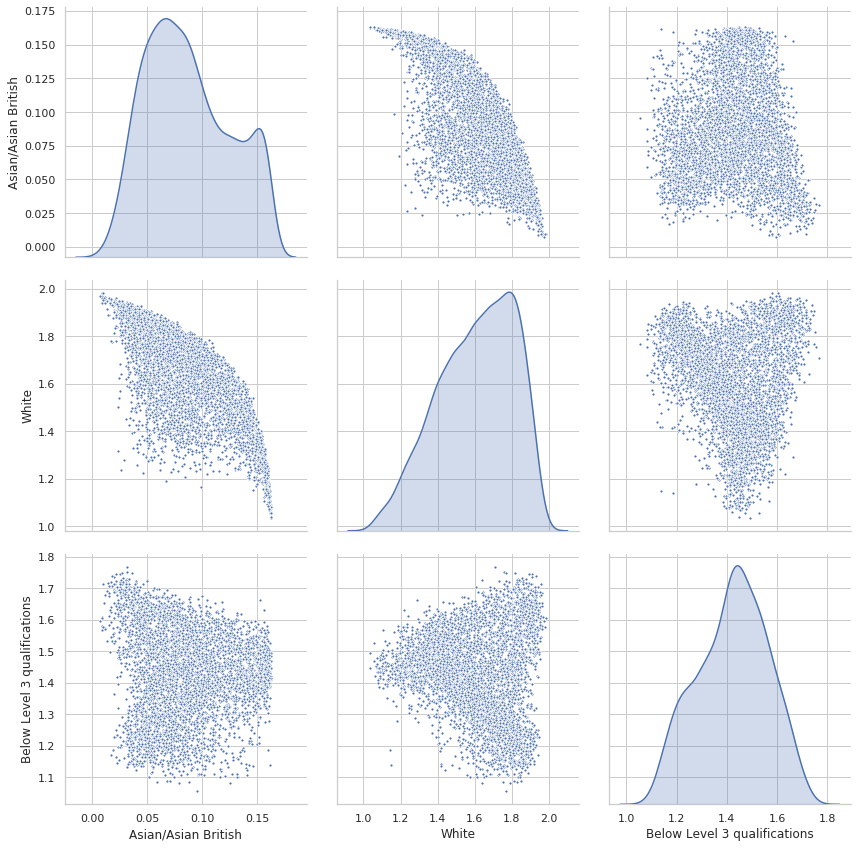

In [101]:
# The data as it is now...
sns.set(style="whitegrid")
sns.pairplot(lsoac, 
             vars=[
                'Asian/Asian British',
                'White',
                'Below Level 3 qualifications'], 
             markers=".", height=4, diag_kind='kde')

So there are clearly some differences, but I'd be hard-pressed to give you sensible clusters just by looking at this data.

### Standardisation with SKLearn

Let's try standardising the data now:

In [102]:
# Here's how we can rescale quickly
from sklearn import preprocessing

Here's the 'original' distribution:

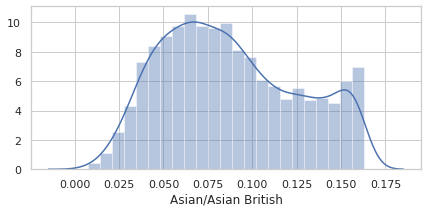

In [104]:
plt.rcParams['figure.figsize']=(7,3)
sns.distplot(lsoac['Asian/Asian British'])

And here's a version that has been rescaled using a MinMax scaler... spot the difference!

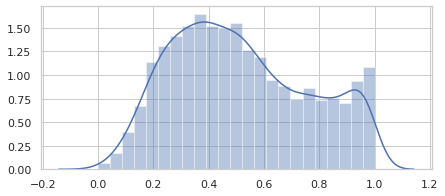

In [108]:
sns.distplot(
    preprocessing.minmax_scale(lsoac['Asian/Asian British'].values.reshape(-1,1)))

In [166]:
# Full copy, not copy by reference
scdf = lsoac.copy(deep=True)

# An alternative if you'd like to try it
#scaler = preprocessing.RobustScaler(quantile_range=[5.0, 95.0])
scaler = preprocessing.MinMaxScaler()

scdf[sdf.columns] = scaler.fit_transform(scdf[scdf.columns])

scdf.describe()

Detached  Semi-detached  Terraced  \
count  4,835.00       4,835.00  4,835.00   
mean       0.42           0.21      0.27   
std        0.27           0.20      0.21   
min        0.00           0.00      0.00   
25%        0.20           0.05      0.10   
50%        0.38           0.14      0.22   
75%        0.59           0.30      0.41   
max        1.00           1.00      1.00   

       Purpose-built block of flats or tenement  \
count                                  4,835.00   
mean                                       0.36   
std                                        0.27   
min                                        0.00   
25%                                        0.14   
50%                                        0.29   
75%                                        0.53   
max                                        1.00   

       Part of a converted or shared house  In a commercial building  \
count                             4,835.00                  4,835.00   
mean                                  0.41                      0.37   
std                                   0.31                      0.31   
min                                   0.00                      0.00   
25%                                   0.13                      0.09   
50%                                   0.33                      0.29   
75%                                   0.69                      0.62   
max                                   1.00                      1.00   

       Age 0 to 14  Age 15 to 24  Age 25 to 44  Age 45 to 64  ...  \
count     4,835.00      4,835.00      4,835.00      4,835.00  ...   
mean          0.43          0.50          0.31          0.54  ...   
std           0.13          0.13          0.14          0.14  ...   
min           0.00          0.00          0.00          0.00  ...   
25%           0.35          0.43          0.22          0.44  ...   
50%           0.43          0.51          0.29          0.53  ...   
75%           0.51          0.58          0.39          0.63  ...   
max           1.00          1.00          1.00          1.00  ...   

       Level 3 qualifications  Level 4 qualifications and above  \
count                4,835.00                          4,835.00   
mean                     0.62                              0.38   
std                      0.10                              0.19   
min                      0.00                              0.00   
25%                      0.56                              0.23   
50%                      0.62                              0.35   
75%                      0.69                              0.52   
max                      1.00                              1.00   

       Other qualifications  In employment  Unemployed  Full-time student  \
count              4,835.00       4,835.00    4,835.00           4,835.00   
mean                   0.35           0.66        0.26               0.53   
std                    0.19           0.12        0.13               0.17   
min                    0.00           0.00        0.00               0.00   
25%                    0.20           0.58        0.16               0.41   
50%                    0.32           0.67        0.25               0.53   
75%                    0.47           0.74        0.35               0.65   
max                    1.00           1.00        1.00               1.00   

       Retired  Looking after home or family  Long-term sick or disabled  \
count 4,835.00                      4,835.00                    4,835.00   
mean      0.36                          0.33                        0.17   
std       0.15                          0.14                        0.10   
min       0.00                          0.00                        0.00   
25%       0.25                          0.23                        0.09   
50%       0.33                          0.31                        0.15   
75%       0.44                          0.41     

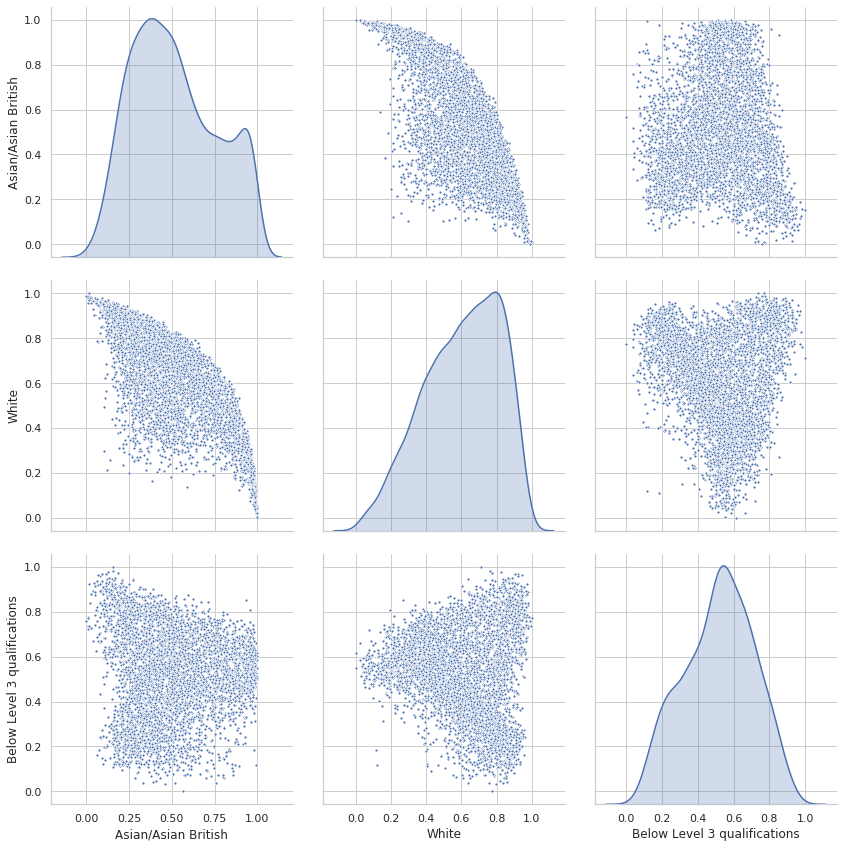

In [167]:
# The data as it is now...
sns.set(style="whitegrid")
sns.pairplot(scdf, 
             vars=[
                'Asian/Asian British',
                'White',
                'Below Level 3 qualifications'], 
             markers=".", height=4, diag_kind='kde')

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Making sure that you understand how and why this results differns from the <i>same</i> plot above.</div>

Right, so you can see that rescaling the dimension hasn't *actually* changed the relationships within each dimension, or even between dimensions, but it has changed the overall range so that the the data is broadly re-centered on 0 but we *still* have the original outliers from the raw data. You could _also_ do IQR standardisation (0.25 and 0.75) with the percentages, but in those cases you would have _more_ outliers and then _more_ extreme values skewing the results of the clustering algorithm.

### A Step Too Far?

The standardisation process has given us a better perspective on _where_ high concentrations of different groups might be found, but we still need to decide whether the clustering or other machine learning processes should be influenced by the full range of the data. I followed the approach outlined in _Geocomputation_, but in some ways I lean towards _not_ completely rescaling on the basis that super-high concentrations of particular groups _should_ have a significant impact on the results of the clustering process; however, using robust rescaling (allowing outliers to persist) does mean that we're more likely to get one large cluster containing the bulk of the non-extreme data and a number of small clusters each containing a small number of 'extreme' LSOAs. **Can you think why?**

My point is that the right choice is the one that you can argue logically and consistently for. There are plenty of researchers who would disagree with me on the paragraph above, but that doesn't mean I'm wrong. Nor does it mean they're wrong.

## Considering Correlated Variables (a.k.a. Feature Selection)

Depending on the clustering technique, correlated variables can have an unexpected effect on the results by allowing some dimensions to be 'double-weighted' in the results. So we don't want to keep too many correlated variables in the clustering data since that will bias the clustering algorithms and may result in poor 'performance'. 

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Think about _why_ correlation between two variables could lead to 'double-weighting in the clustering results!</div>

One way to deal this is to produce a correlation table for all variables and then look to remove problematic variables. For a gentle introduction (that kinds of leaves you hanging at the end) there's a nice-looking blog post on [Medium](https://medium.com/towards-artificial-intelligence/feature-selection-and-dimensionality-reduction-using-covariance-matrix-plot-b4c7498abd07): 

> Feature selection and dimensionality reduction are important because of three main reasons:
> - Prevents Overfitting: A high-dimensional dataset having too many features can sometimes lead to overfitting (model captures both real and random effects).
> - Simplicity: An over-complex model having too many features can be hard to interpret especially when features are correlated with each other.
> - Computational Efficiency: A model trained on a lower-dimensional dataset is computationally efficient (execution of algorithm requires less computational time).
> Dimensionality reduction, therefore, plays a crucial role in data preprocessing.

There's also [this post](https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf) and [this one](https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4). We could also use Principal Components Analysis (PCA) to perform dimensionality reduction whilst also dealing with correlation between the variables.

In [168]:
# Here's an output table which gives you nice, specific 
# numbers but is hard to read so I'm only showing the 
# first ten rows and columns... 
scdf.corr().iloc[1:10,1:10]

Semi-detached  Terraced  \
Semi-detached                                      1.00     -0.02   
Terraced                                          -0.02      1.00   
Purpose-built block of flats or tenement          -0.61     -0.54   
Part of a converted or shared house               -0.44     -0.08   
In a commercial building                          -0.19     -0.09   
Age 0 to 14                                        0.10      0.31   
Age 15 to 24                                      -0.03      0.02   
Age 25 to 44                                      -0.60     -0.14   
Age 45 to 64                                       0.59      0.08   

                                          Purpose-built block of flats or tenement  \
Semi-detached                                                                -0.61   
Terraced                                                                     -0.54   
Purpose-built block of flats or tenement                                      1.00   
Part of a converted or shared house                                          -0.02   
In a commercial building                                                      0.07   
Age 0 to 14                                                                  -0.07   
Age 15 to 24                                                                  0.17   
Age 25 to 44                                                                  0.41   
Age 45 to 64                                                                 -0.53   

                                          Part of a converted or shared house  \
Semi-detached                                                           -0.44   
Terraced                                                                -0.08   
Purpose-built block of flats or tenement                                -0.02   
Part of a converted or shared house                                      1.00   
In a commercial building                                                 0.31   
Age 0 to 14                                                             -0.33   
Age 15 to 24                                                            -0.20   
Age 25 to 44                                                             0.57   
Age 45 to 64                                                            -0.31   

                                          In a commercial building  \
Semi-detached                                                -0.19   
Terraced                                                     -0.09   
Purpose-built block of flats or tenement                      0.07   
Part of a converted or shared house                           0.31   
In a commercial building                                      1.00   
Age 0 to 14                                                  -0.24   
Age 15 to 24                                                  0.02   
Age 25 to 44                                                  0.29   
Age 45 to 64                                                 -0.21   

                                          Age 0 to 14  Age 15 to 24  \
Semi-detached                                    0.10         -0.03   
Terraced                                         0.31          0.02   
Purpose-built block of flats or tenement        -0.07          0.17   
Part of a converted or shared house             -0.33         -0.20   
In a commercial building                        -0.24          0.02   
Age 0 to 14                                      1.00          0.13   
Age 15 to 24                                     0.13          1.00   
Age 25 to 44                                    -0.40         -0.14   
Age 45 to 64                                    -0.04         -0.31   

                                          Age 25 to 44  Age 45 to 64  
Semi-detached                                    -0.60          0.59  
Terraced                                         -0.14          0.08  
Purpose-built block of flats or tenement          0.41

### Finding Strong Correlations Visually

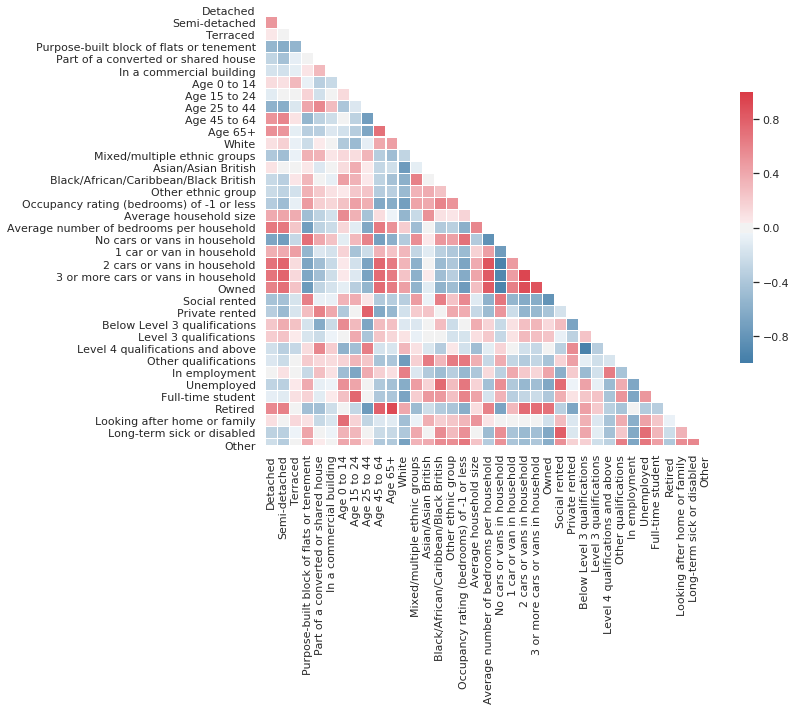

In [169]:
# And here's a correlation heatmap... which is easier to read but has
# less detail. What it *does* highlight is high levels of *negative*
# correlation as well as positive, so you'll need absolute difference, 
# not just whether something is more than 0.x correlated.
# 
# From https://seaborn.pydata.org/examples/many_pairwise_correlations.html
cdf = scdf.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(cdf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cm = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cdf, mask=mask, cmap=cm, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5})

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Make sure that you understand what the figure above is showing before proceeding to the next stage.</div>

### Finding Strong Correlations Numerically

In [195]:
# Generate the matrix but capture the output this time
cdf = scdf.corr()
cdf['name'] = cdf.index # We need a copy of the index

In [200]:
corrh = 0.66 # Specify threshold for highly correlated?
print("! High correlation threshold is {0}.".format(corrh))

num_corrs = []
hi_corrs  = []

for c in cdf.name.unique():
    if c != 'name':
        # Some formatting
        print("=" * 10 + f" {c} " + "=" * 10)
        
        # Find highly correlated variables
        hits = cdf.loc[(abs(cdf[c]) >= corrh), c]
        hits.drop(c, inplace=True)
        
        if hits.size == 0: # No correlations > corrs
            print("+ Not highly correlated with other variables.")
        else:
            num_corrs.append(hits.size)
            
            print("- High correlations ({0}) with other variables:".format(hits.size))
            print("    " + "\n    ".join(hits.index.values))
            hi_corrs.append(hits.size)  

! High correlation threshold is 0.66.
========== Detached ==========
- High correlations (4) with other variables:
    Average number of bedrooms per household
    No cars or vans in household
    2 cars or vans in household
    3 or more cars or vans in household
========== Semi-detached ==========
- High correlations (5) with other variables:
    Average number of bedrooms per household
    No cars or vans in household
    2 cars or vans in household
    3 or more cars or vans in household
    Owned
========== Terraced ==========
+ Not highly correlated with other variables.
========== Purpose-built block of flats or tenement ==========
- High correlations (4) with other variables:
    Average number of bedrooms per household
    No cars or vans in household
    2 cars or vans in household
    Owned
========== Part of a converted or shared house ==========
+ Not highly correlated with other variables.
========== In a commercial building ==========
+ Not highly correlated with other v

Text(0.5, 1.0, 'Number of Strong Correlations (> 0.66)  with Other Variables')

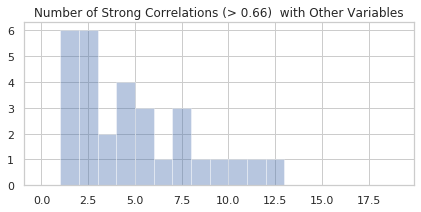

In [172]:
sns.distplot(hi_corrs, bins=range(0,20), kde=False).set_title(
    "Number of Strong Correlations (> " + str(corrh) + ")  with Other Variables")

### Stripping Out 'Redundant' Variables

Let's remove any variable that has a '*lot*' of strong correlations correlations with other variables, though we need to define what is 'a lot'. This will reduce the dimensionality of our data and make clustering a bit easier. An alternative approach to dimensionality reduction -- which can be more 'robust' if we ensure that all of the data has unit variance (which we've done using the MinMaxScaler), though harder for many to understand -- would be to apply Principal Components Analysis (PCA) to the data set and to work with the eigenvalues afterwards. PCA is also available in `sklearn`.

We'll set our threshold at 5.0 based on a visual inspection of the chart above.

In [185]:
corrh     = 0.66 # Specify threshold for highly correlated?
maxcorrs  = 4.0 # What's our threshold for too many strong correlations?
threshold = 0.5*maxcorrs # What's our threshold for too many strong correlations with columns we keep!

print("! High correlation threshold is {0}.".format(corrh))

to_drop = [] # Columns to drop
to_keep = [] # Columns to keep

num_corrs = []
hi_corrs  = []

for c in cdf.columns:
    if c != 'name':
        
        # Find highly correlated variables, but let's
        # keep the focus on *positive* correlation now
        hits = cdf.loc[(cdf[c] >= corrh), c]
        hits.drop(c, inplace=True)
        
        multi_vals = False
        
        # Remove ones with many correlations
        if hits.size >= maxcorrs: 
            print(f"- {c} exceeds maxcorr ({maxcorrs}) correlation threshold (by {hits.size-threshold}).")
            s1 = set(to_keep)
            s2 = set(hits.index.values)
            #print("Comparing to_keep (" + ", ".join(s1) + ") to hits (" + ", ".join(s2) + ")")
            s1 &= s2
            #print("Column found in 'many correlations' :" + str(s1))
            if len(s1) >= threshold: 
                multi_vals = True
                print(f"    - Dropping b/c exceed {threshold} correlations with retained cols: \n        -" + "\n        -".join(s1))
            else:
                print(f"    + Keeping b/c fewer than {threshold} correlations with retained columns.")
        else: 
            print(f"+ {c} falls below maxcorr ({maxcorrs}) correlation threshold (by {abs(threshold-hits.size)}).")
            
        if multi_vals==True:
            to_drop.append(c)
        else:
            to_keep.append(c)
        

print(" ")
print("To drop ({0}): ".format(len(to_drop)) + ", ".join(to_drop))
print(" ")
print("To keep ({0}): ".format(len(to_keep)) + ", ".join(to_keep))

+ Detached falls below maxcorr (4.0) correlation threshold (by 1.0).
- Semi-detached exceeds maxcorr (4.0) correlation threshold (by 2.0).
    + Keeping b/c fewer than 2.0 correlations with retained columns.
+ Terraced falls below maxcorr (4.0) correlation threshold (by 2.0).
+ Purpose-built block of flats or tenement falls below maxcorr (4.0) correlation threshold (by 1.0).
+ Part of a converted or shared house falls below maxcorr (4.0) correlation threshold (by 2.0).
+ In a commercial building falls below maxcorr (4.0) correlation threshold (by 2.0).
+ Age 0 to 14 falls below maxcorr (4.0) correlation threshold (by 1.0).
+ Age 15 to 24 falls below maxcorr (4.0) correlation threshold (by 1.0).
+ Age 25 to 44 falls below maxcorr (4.0) correlation threshold (by 1.0).
- Age 45 to 64 exceeds maxcorr (4.0) correlation threshold (by 3.0).
    + Keeping b/c fewer than 2.0 correlations with retained columns.
+ Age 65+ falls below maxcorr (4.0) correlation threshold (by 0.0).
+ White falls bel

In [202]:
to_save = scdf.drop(to_drop, axis=1, errors='raise')
print("Retained variables: " + ", ".join(to_save.columns.values))
to_save.to_pickle(os.path.join('data','LSOA_2Cluster.pickle'))
del(to_save)

Retained variables: Detached, Semi-detached, Terraced, Purpose-built block of flats or tenement, Part of a converted or shared house, In a commercial building, Age 0 to 14, Age 15 to 24, Age 25 to 44, Age 45 to 64, Age 65+, White, Mixed/multiple ethnic groups, Asian/Asian British, Black/African/Caribbean/Black British, Other ethnic group, Occupancy rating (bedrooms) of -1 or less, Average household size, No cars or vans in household, 1 car or van in household, Social rented, Private rented, Below Level 3 qualifications, Level 3 qualifications, Level 4 qualifications and above, Other qualifications, In employment, Full-time student, Looking after home or family, Long-term sick or disabled, Other


<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Make sure that you understand what we have done and why in this section of the pratical.</div>

## Clustering Your Data

OK, we're finally here! It's time to cluster the cleaned, normalised, and standardised data set! We're going to start with the best-known clustering technique (k-means) and work from there... Don't take my word for it, here are the [5 Clustering Techniques Every Data Scientist Should Know](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68). This is also a good point to refer back to some of what we've been doing (and it's a good point to potentially disagree with me!) since [clustering in high dimensions can be problematic](https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6) (_i.e._ the more dimensions the worse the Euclidean distance gets as a cluster metric).

The effectiveness of clustering algorithms is usually demonstrated using the 'iris data' -- it's available by default with both Seaborn and SciKit-Learn. This data doesn't usually need normalisation but it's a good way to start looking at the data across four dimensions and seeing how it varies and why some dimensions are 'good' for clustering, while others are 'not useful'...

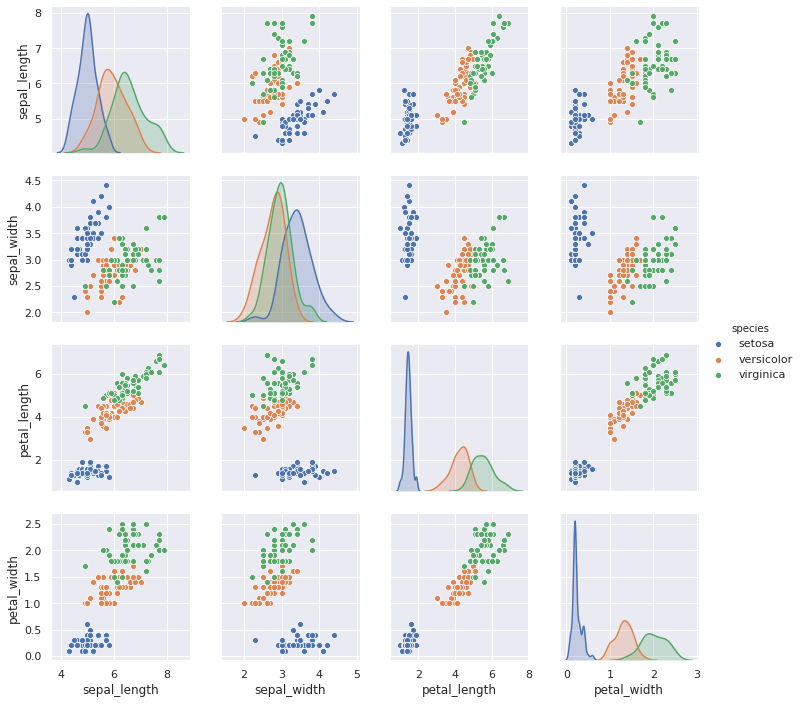

In [159]:
sns.set()
irises = sns.load_dataset("iris")
sns.pairplot(irises, hue="species")

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">Unfortunately, our data is a <i>lot</i> messier and has many more dimensions (>25) than this.</div>

#### Create an Output Directory and Load the Data

In [190]:
o_dir = os.path.join('outputs','clusters')
if os.path.isdir(o_dir) is not True:
    print("Creating '{0}' directory for images.".format(o_dir))
    os.mkdir(o_dir)

In [446]:
df = pd.read_pickle(os.path.join('data','LSOA_2Cluster.pickle'))
df.sample(3, random_state=42)

Detached  Semi-detached  Terraced  \
E01001500      0.46           0.16      0.66   
E01000551      0.13           0.01      0.03   
E01003220      0.25           0.10      0.48   

           Purpose-built block of flats or tenement  \
E01001500                                      0.08   
E01000551                                      0.86   
E01003220                                      0.09   

           Part of a converted or shared house  In a commercial building  \
E01001500                                 0.59                      0.21   
E01000551                                 0.47                      0.25   
E01003220                                 0.91                      0.30   

           Age 0 to 14  Age 15 to 24  Age 25 to 44  Age 45 to 64  ...  \
E01001500         0.44          0.50          0.25          0.61  ...   
E01000551         0.62          0.49          0.29          0.47  ...   
E01003220         0.39          0.57          0.28          0.57  ...   

           Private rented  Below Level 3 qualifications  \
E01001500            0.29                          0.54   
E01000551            0.08                          0.69   
E01003220            0.27                          0.55   

           Level 3 qualifications  Level 4 qualifications and above  \
E01001500                    0.62                              0.32   
E01000551                    0.58                              0.21   
E01003220                    0.66                              0.36   

           Other qualifications  In employment  Full-time student  \
E01001500                  0.52           0.65               0.60   
E01000551                  0.45           0.49               0.63   
E01003220                  0.28           0.67               0.64   

           Looking after home or family  Long-term sick or disabled  Other  
E01001500                          0.33                        0.16   0.27  
E01000551                          0.41                        0.33   0.55  
E01003220                          0.22                        0.24   0.44  

[3 rows x 31 columns]

In [212]:
df.iloc[:,0:5].max() # Should be 1 for first 5 columns if we loaded the right data

Detached                                   1.00
Semi-detached                              1.00
Terraced                                   1.00
Purpose-built block of flats or tenement   1.00
Part of a converted or shared house        1.00
dtype: float64

#### Grab Borough Boundaries and Water Courses

_Note:_ if reading these GeoPackages gives you errors then you will need to comment out the following two lines from the `plt_ldn` function immediately below:
```python
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
```

In [161]:
# Load Water GeoPackage
w_path = os.path.join('data','Water.gpkg')
if not os.path.exists(w_path):
    water = gpd.read_file('https://github.com/kingsgeocomp/applied_gsa/raw/master/data/Water.gpkg')
    water.to_file(w_path)
    print("Downloaded Water.gpkg file.")
else:
    water = gpd.read_file(w_path)

# Boroughs GeoPackage
b_path = os.path.join('data','Boroughs.gpkg')
if not os.path.exists(b_path):
    boroughs = gpd.read_file('https://github.com/kingsgeocomp/applied_gsa/raw/master/data/Boroughs.gpkg')
    boroughs.to_file(b_path)
    print("Downloaded Boroughs.gpkg file.")
else:
    boroughs = gpd.read_file(b_path)

#### Useful Functions for Plotting

In [439]:
def plt_ldn(w=water, b=boroughs):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

#### Select 4 Columns to Plot

In [223]:
random.seed(42)
cols_to_plot = random.sample(population=list(df.columns.values), k=4)
print("Columns to plot: " + ", ".join(cols_to_plot))

Columns to plot: Age 15 to 24, Semi-detached, Average household size, Other ethnic group


#### Storing Results

In [345]:
result_set = None

def add_2_rs(s, rs=result_set):
    if rs is None:
        # Initialise
        rs = pd.DataFrame()
    rs[s.name] = s
    return rs

### K-Means

#### Importing the Library

In [213]:
from sklearn.cluster import KMeans
#help(KMeans)

The next few code blocks may take a while to complete, largely because of the `pairplot` at the end where we ask Seaborn to plot every dimension against every other dimension _while_ colouring the points according to their cluster. I've reduced the plotting to just three dimensions, if you want to plot all of them, then just replace the array attached to `vars` with `main_cols`, but you have to bear in mind that that is plotting 4,300 points _each_ time it draws a plot... and there are 81 of them! It'll take a while, but it _will_ do it, and try doing that in Excel or SPSS?

#### A First Cluster Analysis

[4 2 1 ... 0 0 0]


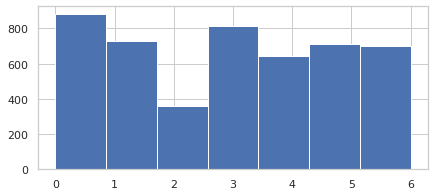

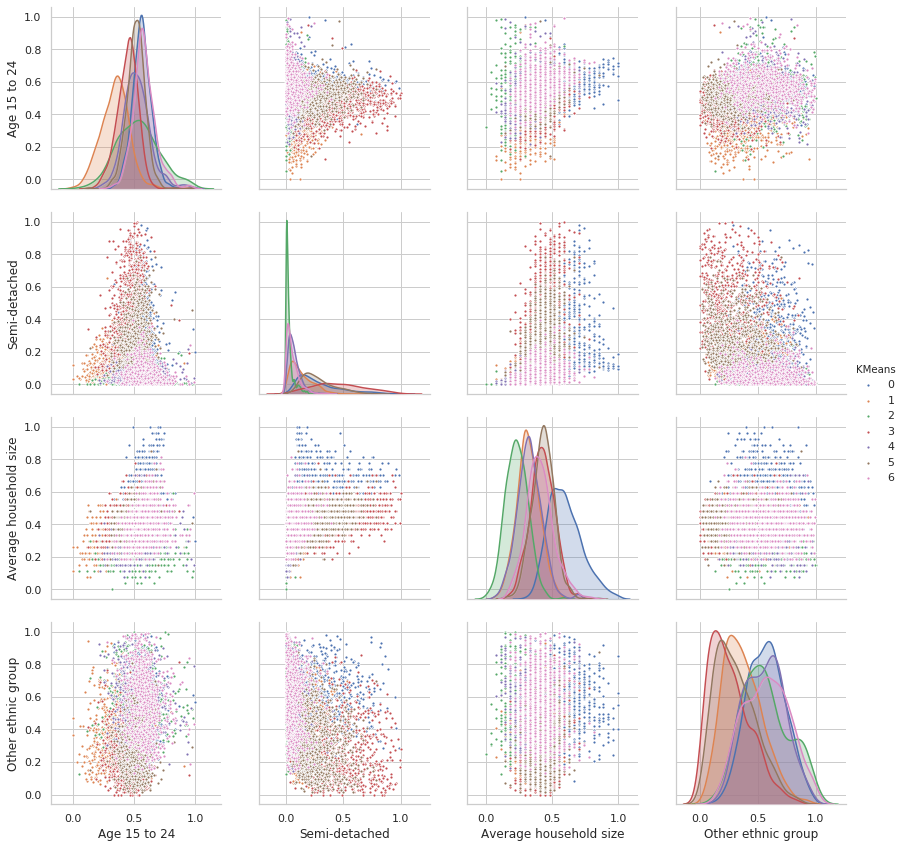

In [227]:
c_nm = 'KMeans' # Clustering name
k    = 4 # Number of clusters

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

kmeans = KMeans(n_clusters=k).fit(cldf) # The process

print(kmeans.labels_) # The results

# Add it to the data frame
cldf[c_nm] = pd.Series(kmeans.labels_, index=df.index) 

# How are the clusters distributed?
cldf[c_nm].hist(bins=k)

# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a few
sns.set(style="whitegrid")
sns.pairplot(cldf, 
             vars=cols_to_plot, 
             hue=c_nm, markers=".", height=3, diag_kind='kde')

del(cldf)

#### One More Thing...

There's just _one_ little problem: what assumption did I make when I started this *k*-means cluster analysis? It's a huge one, and it's one of the reasons that *k*-means clustering _can_ be problematic when used naively...

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. What critical assumption did we make when running this analysis?</div>

#### The 'Right' Number of Clusters

Again, there's more than one way to skin this cat. In _Geocomputation_ they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (`2...n`) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always _some_ benefit to adding more clusters (the perfect clustering is _k==n_), so you don't always see a knee. 

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM). 

Either way, to evaluate this in a systematic way, we want to do _multiple_ _k_-means clusterings for _multiple_ values of _k_ and then we can look at which gives the best results...

Let's try it for the range 3-9.

Cluster count: 3
For k = 3 The average silhouette_score is : 0.4273499716231017


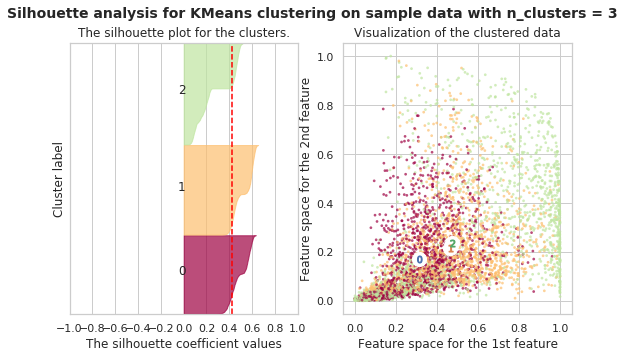

Cluster count: 4
For k = 4 The average silhouette_score is : 0.3905500251275231


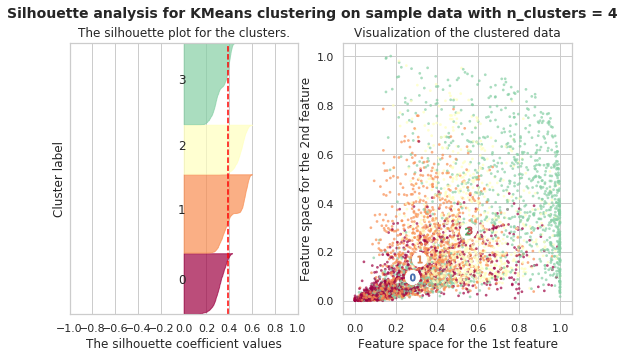

Cluster count: 5
For k = 5 The average silhouette_score is : 0.40616357123250996


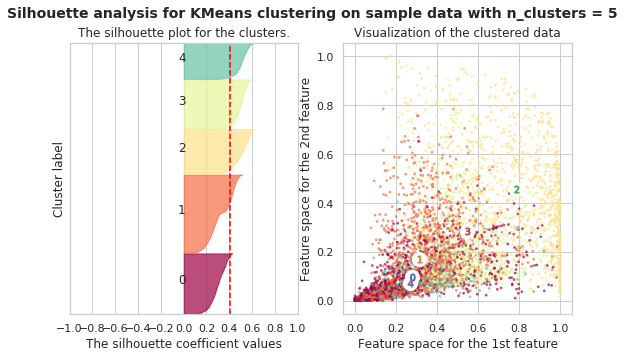

Cluster count: 6
For k = 6 The average silhouette_score is : 0.4295976726058439


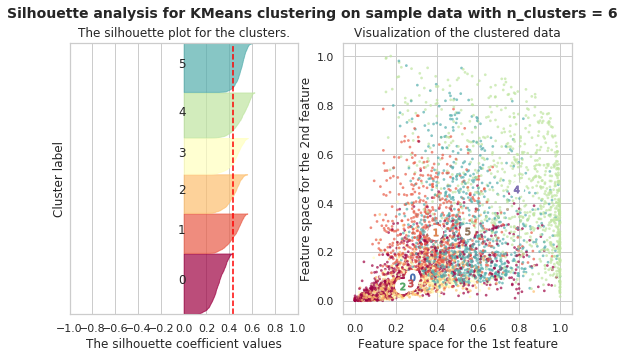

Cluster count: 7
For k = 7 The average silhouette_score is : 0.43830394859255145


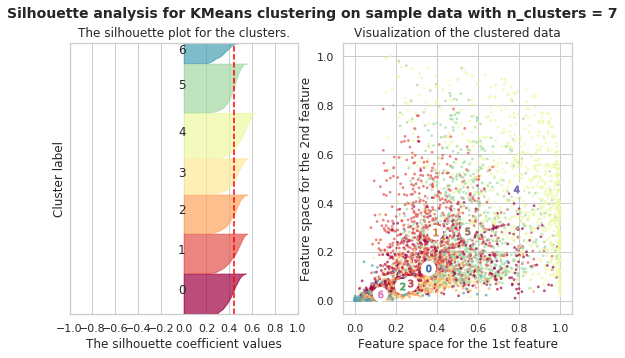

Cluster count: 8
For k = 8 The average silhouette_score is : 0.3864333453941845


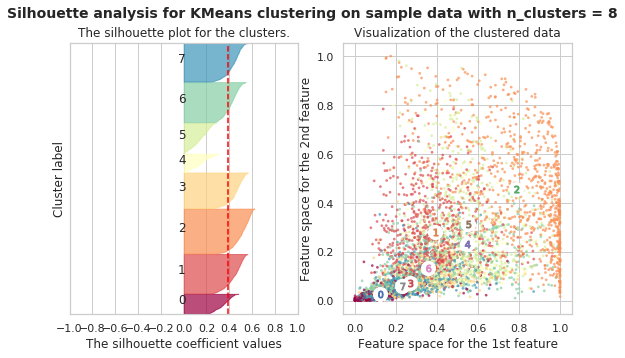

Cluster count: 9
For k = 9 The average silhouette_score is : 0.3243332658351329


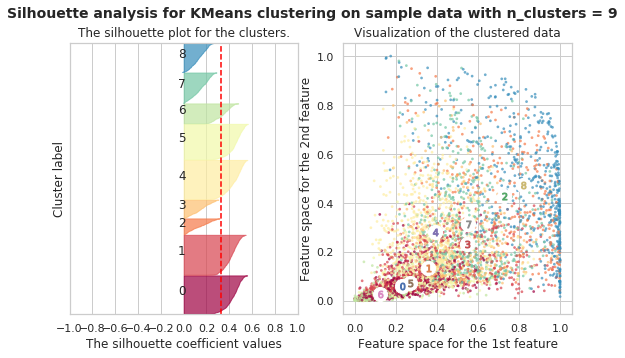

In [239]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

for k in range(3,10):
    # Debugging
    print("Cluster count: " + str(k))
    
    #############
    # Do the clustering using the main columns
    clusterer = KMeans(n_clusters=k, n_init=20, random_state=42)
    cluster_labels = clusterer.fit_predict(cldf)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(cldf, cluster_labels)
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)
    
    # Calculate the silhouette values
    sample_silhouette_values = silhouette_samples(cldf, cluster_labels)
    
    #############
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, cldf.shape[0] + (k + 1) * 10])
    
    y_lower = 10
    
    # For each of the clusters...
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Set the color ramp
        #cmap  = cm.get_cmap("Spectral")
        color = plt.cm.Spectral(i/k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(cluster_labels.astype(float) / k)
    ax2.scatter(cldf[cldf.columns[0]], cldf[cldf.columns[1]], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

    plt.show()
    
del(cldf)

#### Interpreting the Results

Using 15 iterations on each _k_, my results were:

| Cluster Count | Silhouette Score |
|---------------|------------------|
| 3 | 0.427 |
| 4 | 0.391 |
| 5 | 0.406 | 
| 6 | 0.430 |
| 7 | 0.438 |
| 8 | 0.386 | 
| 9 | 0.324 |

Your results may differ, though hopefully not by too much!

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Make sure that you understand how the silhouette plot and value work, and why your results may diverge form mine.</div>

When I ran *k*-means, the results suggested that 7 clusters was probably 'best' -- but note that that's only if we don't have any kind of underlying _theory_, other _empirical evidence_, or just a _reason_ for choosing a different value... Again, we're now getting in areas where _your judgement_ and your ability to _communicate your rationale_ to readers is the key thing. 

#### Final Clustering

Let's repeat the 7-cluster process and then map it.

In [453]:
c_nm = 'KMeans'
# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

k_pref = 7
kmeans = KMeans(n_clusters=k_pref, n_init=20, random_state=42).fit(cldf)

# Convert to a series
s = pd.Series(kmeans.labels_, index=cldf.index, name=c_nm)

# We do this for plotting
cldf[c_nm] = s

# We do this to keep track of the results
result_set=add_2_rs(s)

#### Mapping Results

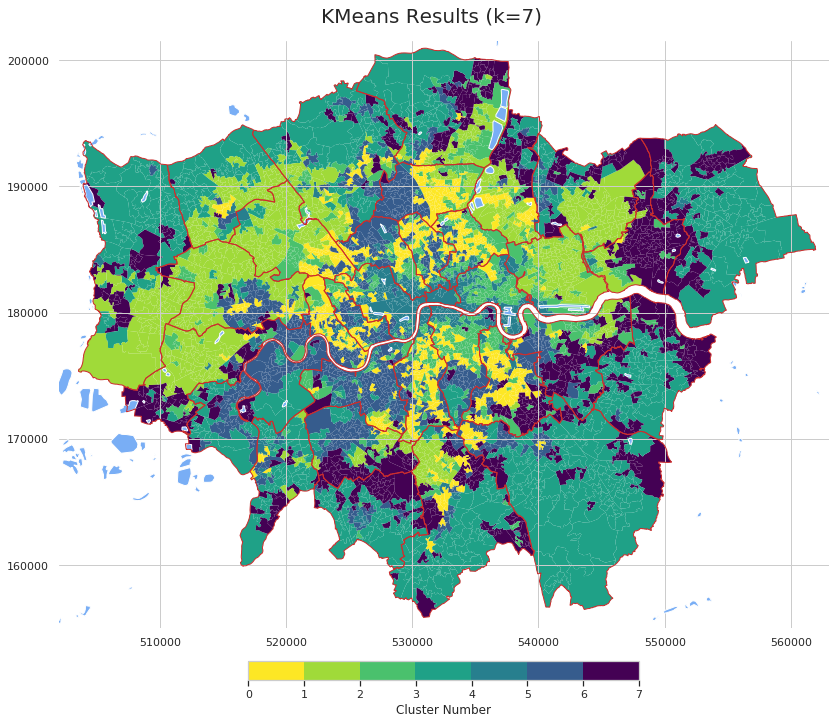

In [455]:
cgdf = gdf.join(cldf, how='inner')

breaks = np.arange(0,cldf[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks))

norm    = mpl.colors.BoundaryNorm(breaks, cmap.N)

fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
cgdf.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks)

plt.savefig(os.path.join(o_dir,f"{c_nm}-{k_pref}.png"), dpi=200)
del(cgdf)

To make sense of whether this is a 'good' result, you might want to visit [datashine](http://datashine.org.uk/#table=QS607EW&col=QS607EW0050&ramp=RdYlGn&layers=BTTT&zoom=10&lon=-0.1751&lat=51.4863) or think back to last year when we examined the NS-SeC data. 

You could also think of ways of plotting how these groups differ. For instance...

#### 'Representative' Centroids

To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). In the case of _k_-means this will work quite will since the clusters are explicitly built around mean centroids. There's also a _k_-medoids clustering approach built around the median centroid.

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5
Processing cluster 6


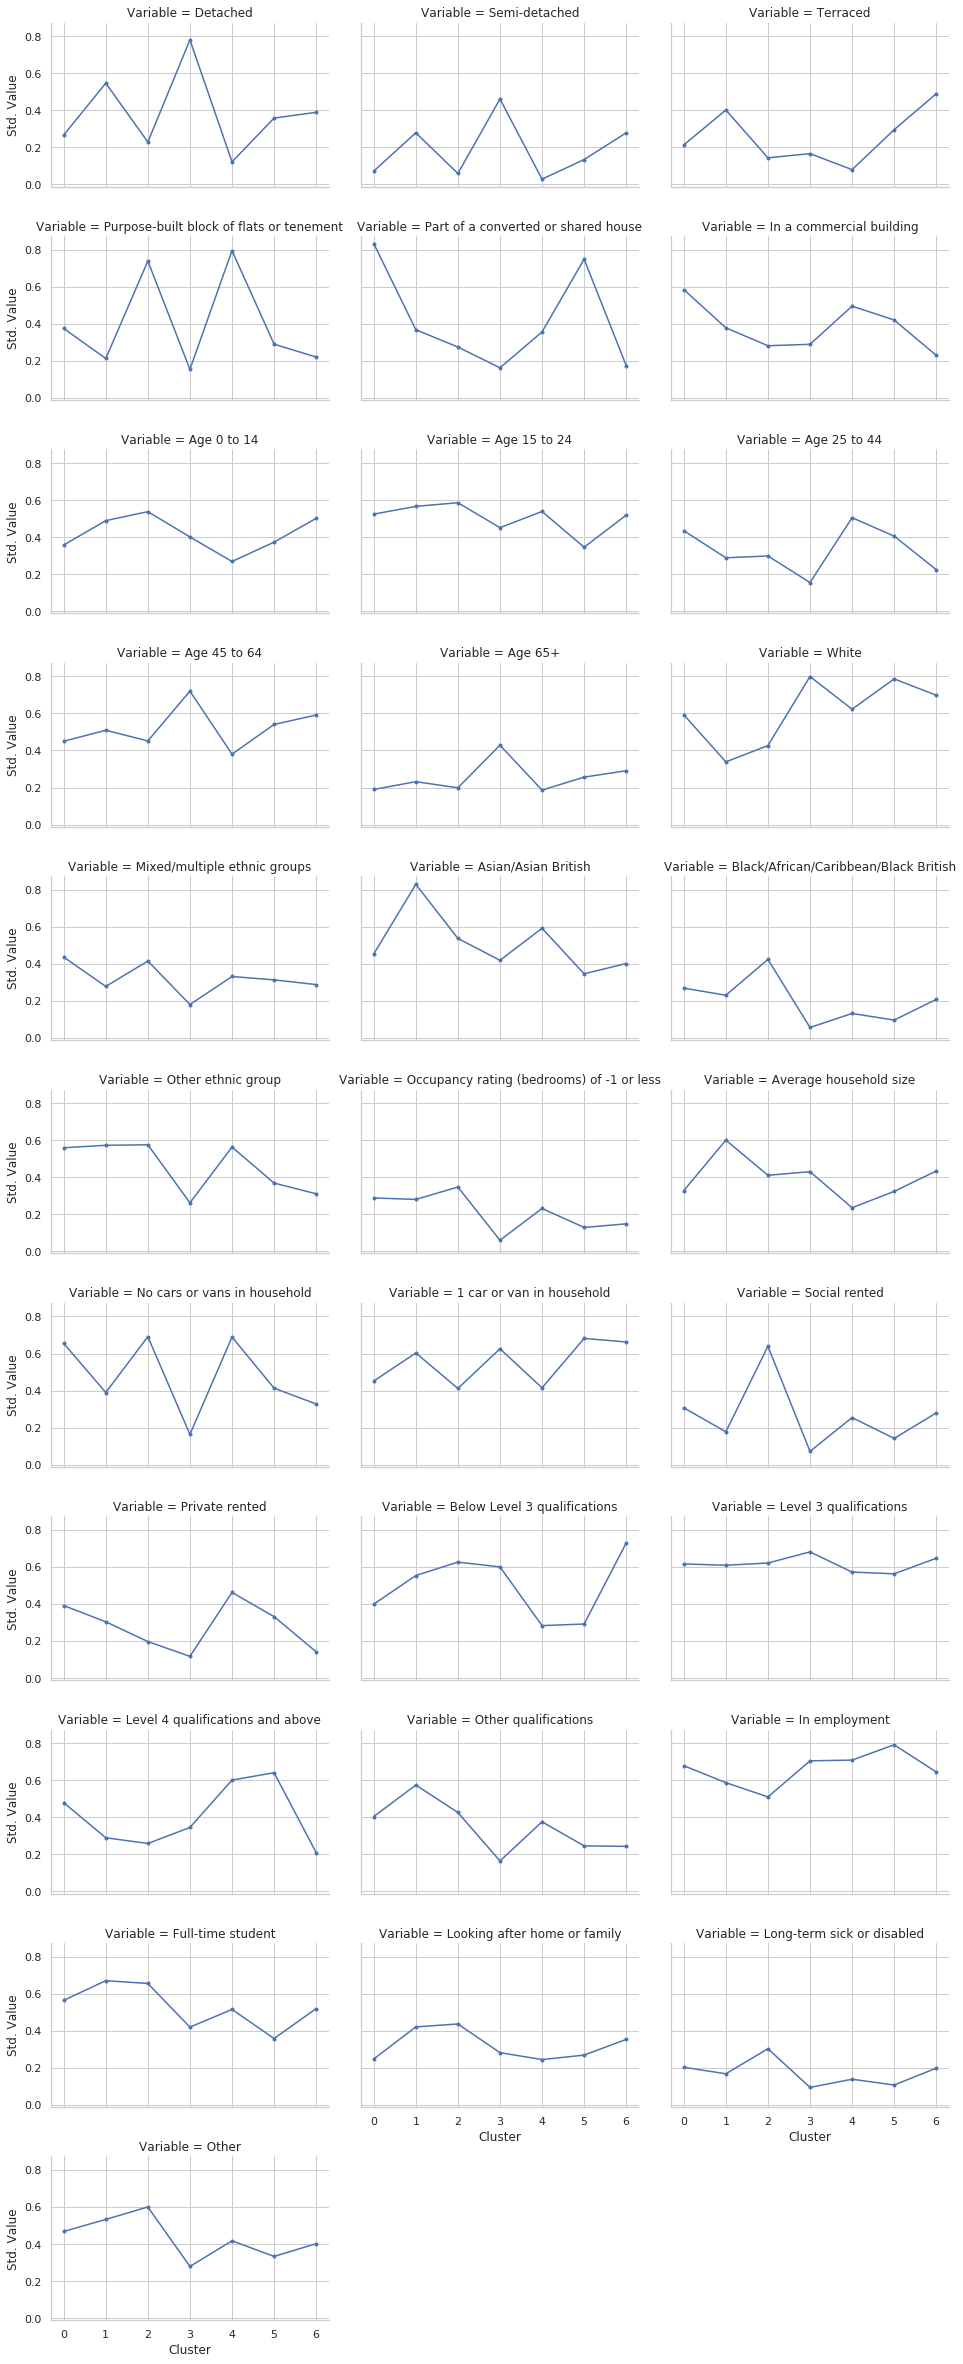

In [456]:
centroids = None
for k in sorted(cldf[c_nm].unique()):
    print(f"Processing cluster {k}")

    clsoas = cldf[cldf[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=clsoas.columns.values)
    centroids = centroids.append(clsoas.mean(), ignore_index=True)

odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

del(odf, centroids, cldf)

#### *Really, really important*

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Now would be a good time to think about _how_ standardisation and normalisation would have changed your results... and you might want to test whether applying these in a 'stronger' format (e.g. sklearn's <code>robust_rescale</code> and scipy's <code>boxcox</code>) help or hinder your analysis!</div>

### DBScan

Of course, as we've said above _k_-means is just one way of clustering, DBScan is another. Unlike _k_-means, we don't need to specify the number of clusters in advance. Which sounds great, but we still need to specify _other_ parameters (typically, these are known as _hyperparameters_ because they are about specifying parameters that help the aglorithm to find the right solution... or final set of parameters!) and these can have a huge impact on our results!

#### Importing the Library

In [347]:
from sklearn.cluster import DBSCAN
#?DSCAN

#### Find a Reasonable Value for Epsilon

Before we an use DBSCAN it's useful to find a good value for Epsilon. We can [look for the point of maximum 'curvature'](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc) in a nearest neigbhours plot. Which seems to be in the vicinity of 0.55. Tips on selecting `min_pts` can be [found here](https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80).

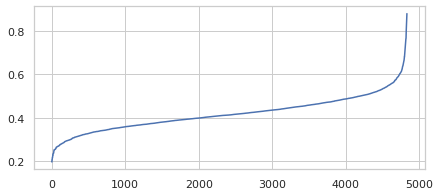

In [488]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cldf)
distances, indices = nbrs.kneighbors(cldf)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### Final Clustering

There are two values that need to be specified: `eps` and `min_samples`. Both seem to be set largely by trial and error. It's easiest to set `min_samples` first since that sets a floor for your cluster size and then `eps` is basically a distance metric that governs how far away something can be from a cluster and still be considered part of that cluster.

In [475]:
c_nm = 'DBSCAN'

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

# Run the clustering
dbs = DBSCAN(eps=0.5, min_samples=33, n_jobs=-1).fit(cldf.values)

# See how we did
s = pd.Series(opt.labels_, index=cldf.index, name=c_nm)
cldf[c_nm] = s
result_set=add_2_rs(s)

# Distribution
print(s.value_counts())

-1    2527
 2    1275
 0     638
 1     219
 4      81
 5      43
 3      17
 7      14
 8      11
 6      10
dtype: int64


#### Mapping Clustering Results

Now that we've got the clustering results we can join it to the geopandas dataframe.

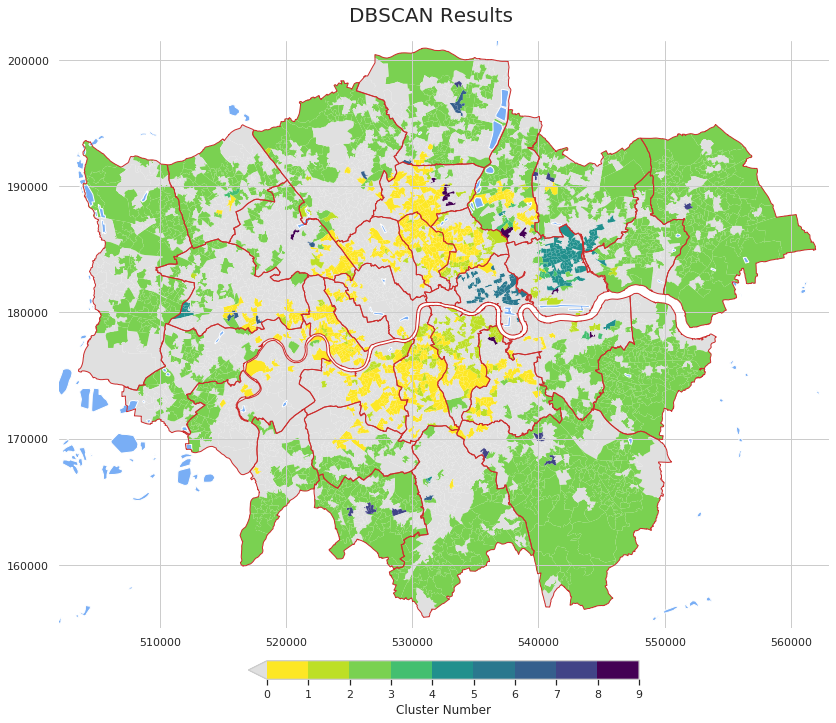

In [476]:
cgdf = gdf.join(cldf, how='inner')

breaks = np.arange(cldf[c_nm].min(),cldf[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks), outliers=True)
norm   = mpl.colors.BoundaryNorm(breaks, cmap.N, clip=False)

fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)

cgdf.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0, legend=False)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks, outliers=True)

plt.savefig(os.path.join(o_dir,f"{c_nm}.png"), dpi=200)
del(cgdf)

#### 'Representative' Centroids

To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). For algorithms other than _k_-means it may be better to use medians than means.

Processing cluster -1
Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5
Processing cluster 6
Processing cluster 7
Processing cluster 8


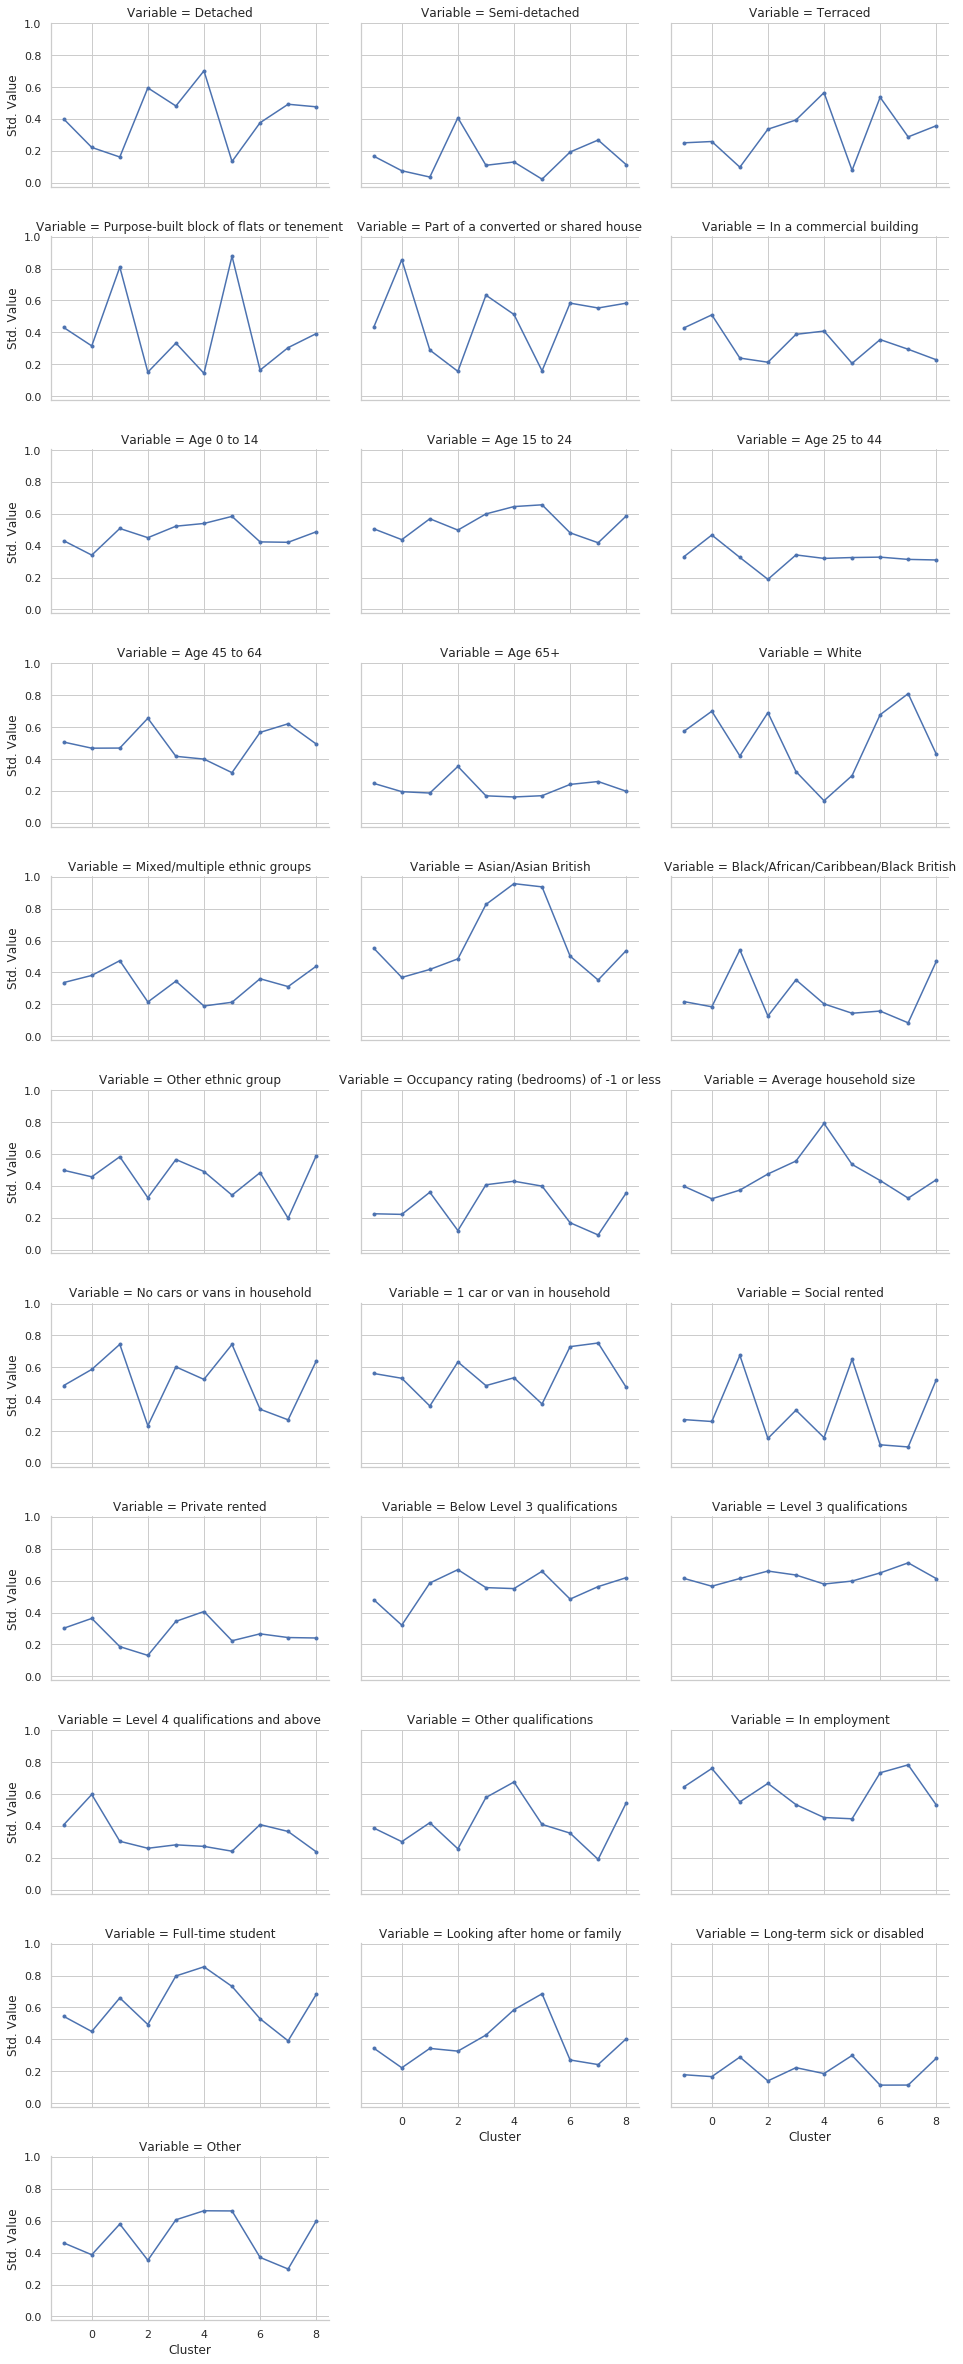

In [477]:
centroids = None
for k in sorted(cldf[c_nm].unique()):
    print(f"Processing cluster {k}")

    clsoas = cldf[cldf[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=clsoas.columns.values)
    centroids = centroids.append(clsoas.mean(), ignore_index=True)

odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

del(odf, centroids, cldf)

### OPTICS Clustering

This is a fairly new addition to `sklearn` and is similar to DBSCAN in that there are very few (if any) parameters to specify. This means that we're making fewer assumptions about the nature of any clustering in the data. It also allows us to have outliers that don't get assigned to _any_ cluster. The focus is mainly on local density, so in some sense it's more like a geographically aware clustering approach, but applied in the data space, not geographical space.

#### Importing the Library

In [478]:
from sklearn.cluster import OPTICS

#### Final Clustering

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. This next step may take quite a lot of time since thie algorithm is making far fewer assumptions about the structure of the data. On a 2018 MacBook Pro with 16GB of RAM it took about 5 minutes.</div>

In [492]:
c_nm = 'Optics'

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

# Run the clustering
opt = OPTICS(min_samples=33, max_eps=0.6, n_jobs=-1).fit(cldf.values)

# See how we did
s = pd.Series(opt.labels_, index=cldf.index, name=c_nm)
cldf[c_nm] = s
result_set=add_2_rs(s)

# Distribution
print(s.value_counts())

 0    4067
-1     768
dtype: int64


#### Mapping Clustering Results

In [ ]:
cgdf = gdf.join(cldf, how='inner')

breaks = np.arange(cldf[c_nm].min(),cldf[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks), outliers=True)
norm   = mpl.colors.BoundaryNorm(breaks, cmap.N, clip=False)

fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)

cgdf.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0, legend=False)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks, outliers=True)

plt.savefig(os.path.join(o_dir,f"{c_nm}.png"), dpi=200)
del(cgdf)

#### 'Representative' Centroids

To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). For algorithms other than _k_-Means it may be better to use medians, not means.

Processing cluster -1
Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5
Processing cluster 6
Processing cluster 7
Processing cluster 8


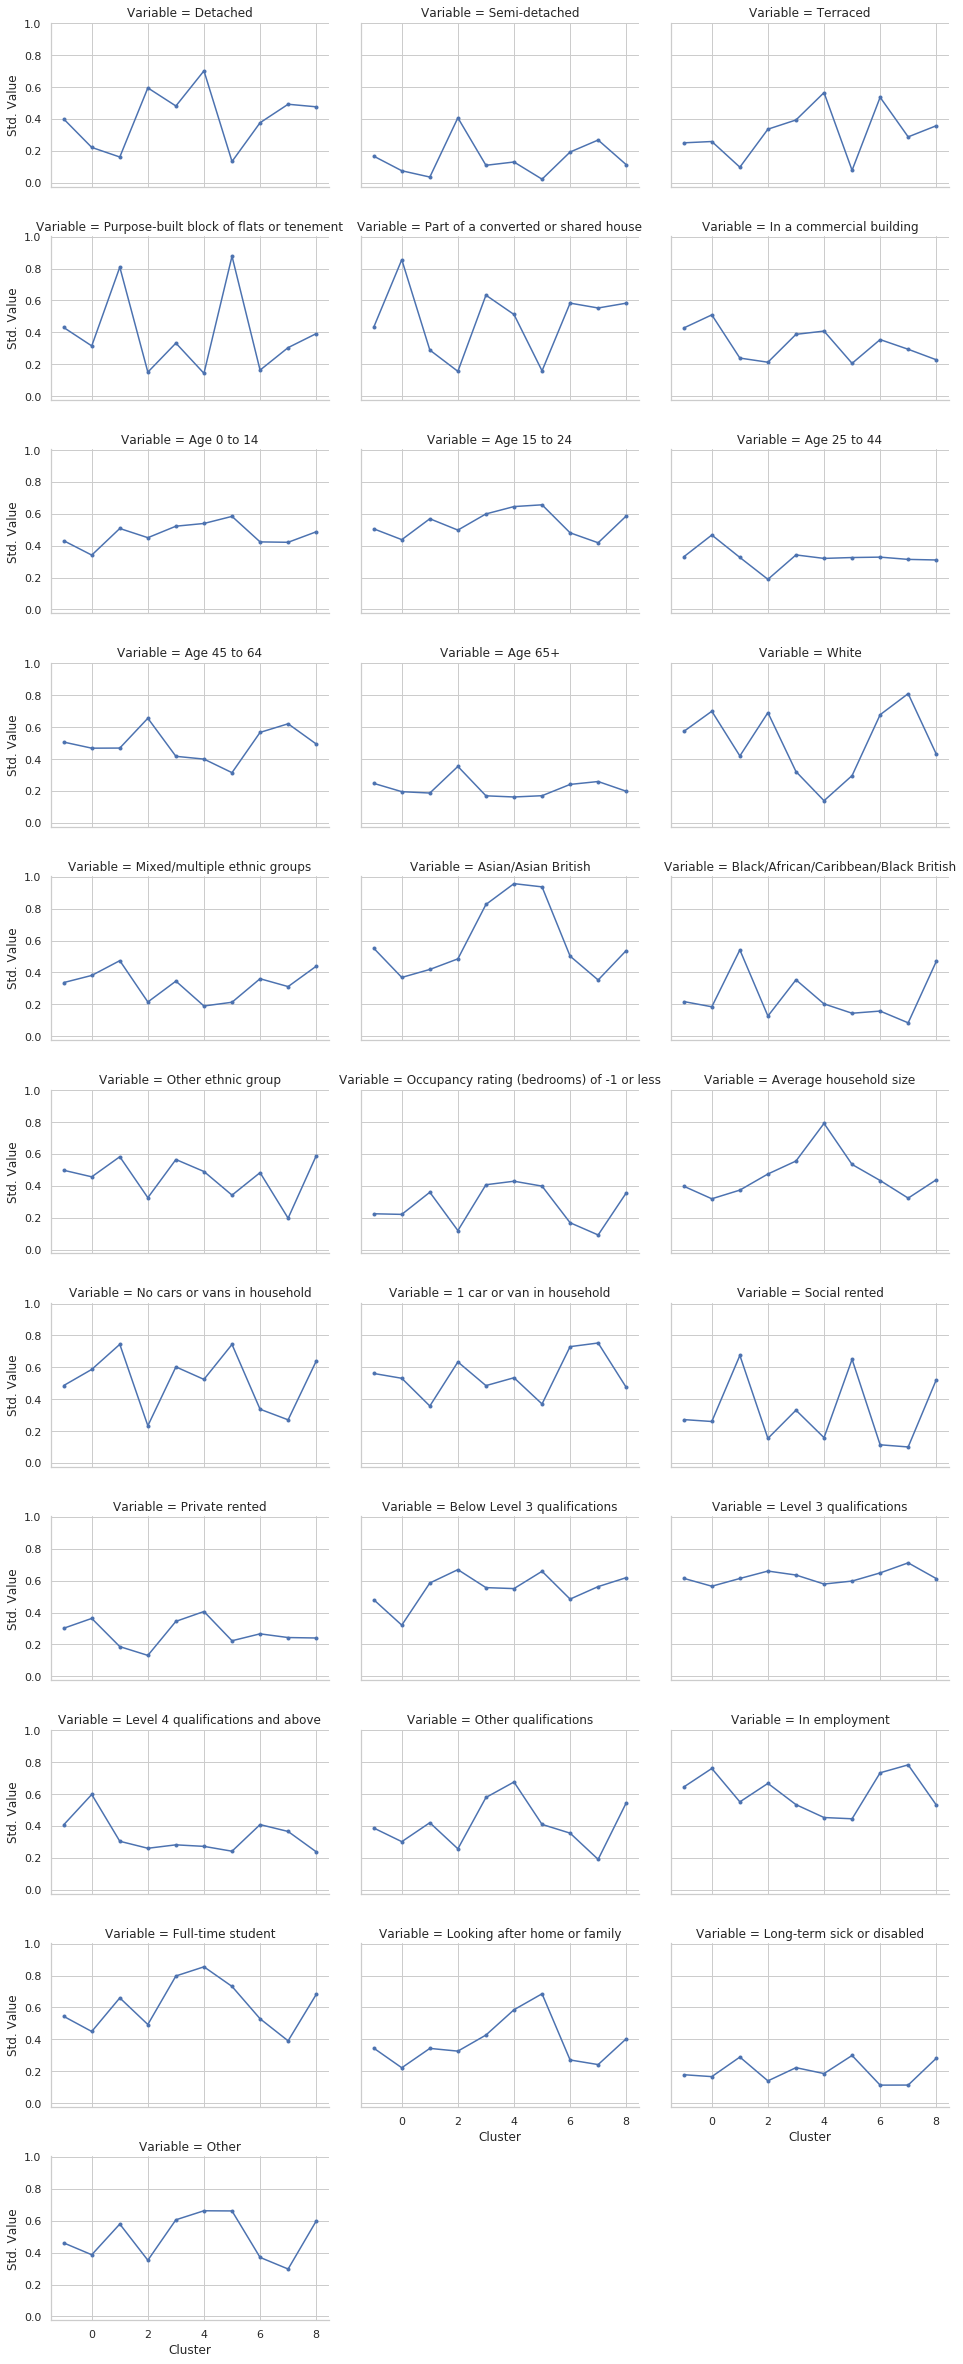

In [477]:
centroids = None
for k in sorted(cldf[c_nm].unique()):
    print(f"Processing cluster {k}")

    clsoas = cldf[cldf[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=clsoas.columns.values)
    centroids = centroids.append(clsoas.mean(), ignore_index=True)

odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

del(odf, centroids, cldf)

### HDBSCAN

Not implemented, but you could give it a try!

### Hierarchical Clustering

Probably not appropriate as it tends to be confused by noise.

### Self-Organising Maps

SOMs offer a third type of clustering algorithm. They are a relatively 'simple' type of neural network in which the 'map' (of the SOM) adjusts to the data: we're going to see how this works over the next few code blocks, but the main thing is that, unlike the above approaches, SOMs build a 2D map of a higher-dimensional space and use this as a mechanism for subsequently clustering the raw data. In this sense there is a conceptual link between SOMs and PCA or tSNE (another form of dimensionality reduction).

#### (Re)Installing SOMPY

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. The maintainers of the main SOMPY library are fairly inactive, so we've had to write our own version that fixes a few Python3 bugs, but this means that it can't be installed the 'usual' way without also having Git installed. Consequently, I have left the output from SOMPY in place so that you can see what it will produce <i>even if you cannot successfully install SOMPY during this practical</i></div>. 

To work out if there is an issue, check to see if the `import` statement below gives you errors:

In [ ]:
from sompy.sompy import SOMFactory

If this import has failed with a warning about being unable to find SOM or something similar, then you will need to *re*-install SOMPY using a fork that I created on our Kings GSA GitHub account. For *that* to work, you will need to ensure that you have `git` installed. 

If the following Terminal command (which should also work in the Windows Terminal) does not give you an error then `git` is already installed:
```shell
git --version
```
To install `git` on a Mac is fairly simple. Again, from the Terminal issue the following command:
```shell
xcode-select --install
```
This installation may take some time over eduroam since there is a lot to download.

Once that's complete, you can move on to installing SOMPY from our fork. On a Mac this is done on the Terminal with:
```shell
conda activate <your kernel name here>
pip install -e git+git://github.com/kingsgeocomp/SOMPY.git#egg=SOMPY
conda deactivate
```
On Windows you probably drop the `conda` part of the command.

#### Training the SOM

We are going to actually train the SOM using the input data. This is where you specify the input parameters that have the main effect on the clustering results.

In [493]:
from sompy.sompy import SOMFactory

In [524]:
c_nm = 'SOM'

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

sm = SOMFactory().build(
    cldf.values, mapsize=(10,15),
    normalization='var', initialization='random', component_names=cldf.columns.values)
sm.train(n_job=4, verbose=False, train_rough_len=2, train_finetune_len=5)

How good is the fit?

In [525]:
topographic_error  = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print("Topographic error = {0:0.5f}; Quantization error = {1:0.5f}".format(topographic_error, quantization_error))

Topographic error = 0.34664; Quantization error = 3.08805


How do the results look?

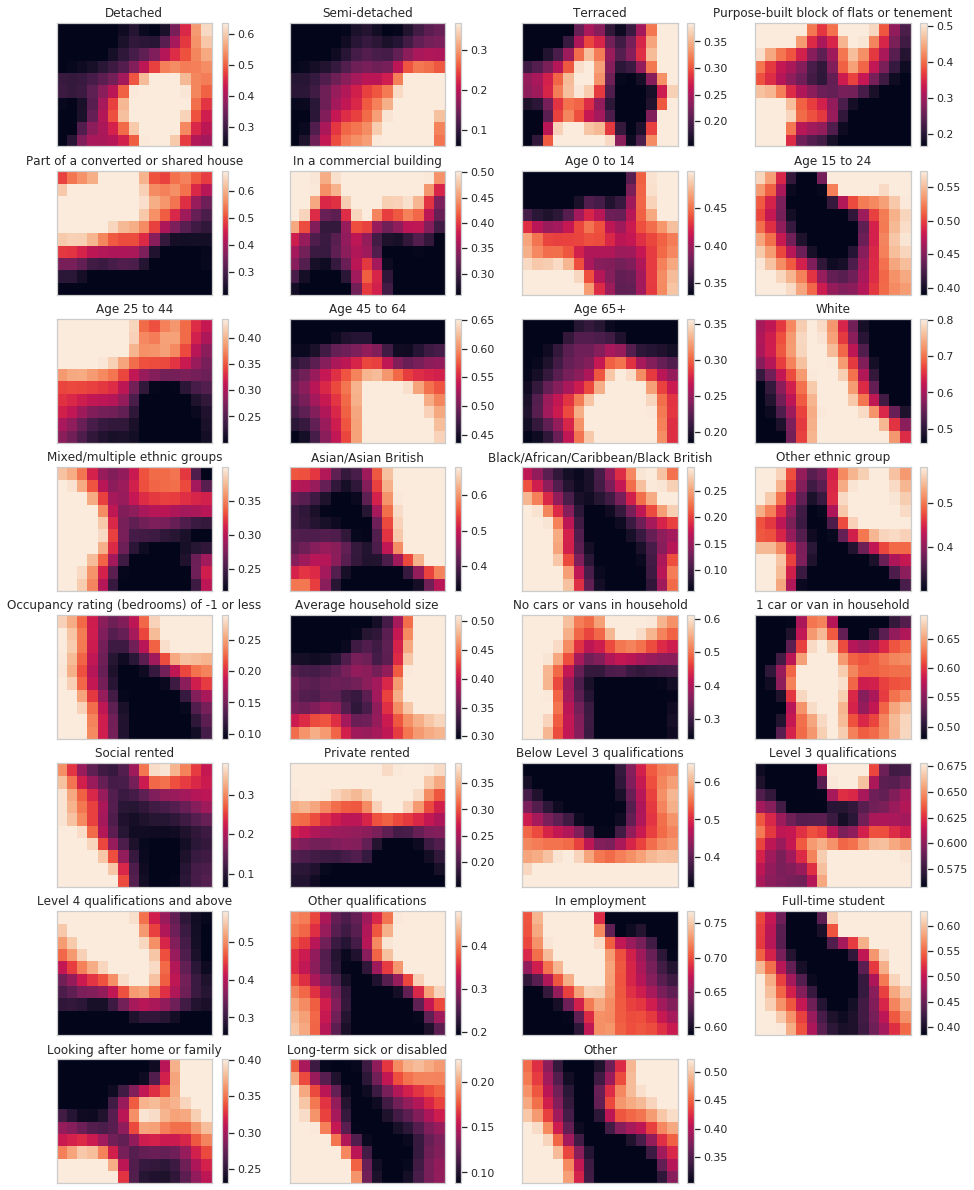

In [526]:
from sompy.visualization.mapview import View2D
view2D = View2D(10, 10, "rand data", text_size=10)
view2D.show(sm, col_sz=4, which_dim="all", denormalize=True)
plt.savefig(os.path.join(o_dir, f"{c_nm}-Map.png"), dpi=200)

#### Here's What I Got

<img src="https://github.com/kingsgeocomp/applied_gsa/raw/master/img/som_results.png" alt="SOM Clustering Results" width="750" />

How many clusters do we want and where are they on the map?

/opt/conda/envs/gsa2019/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


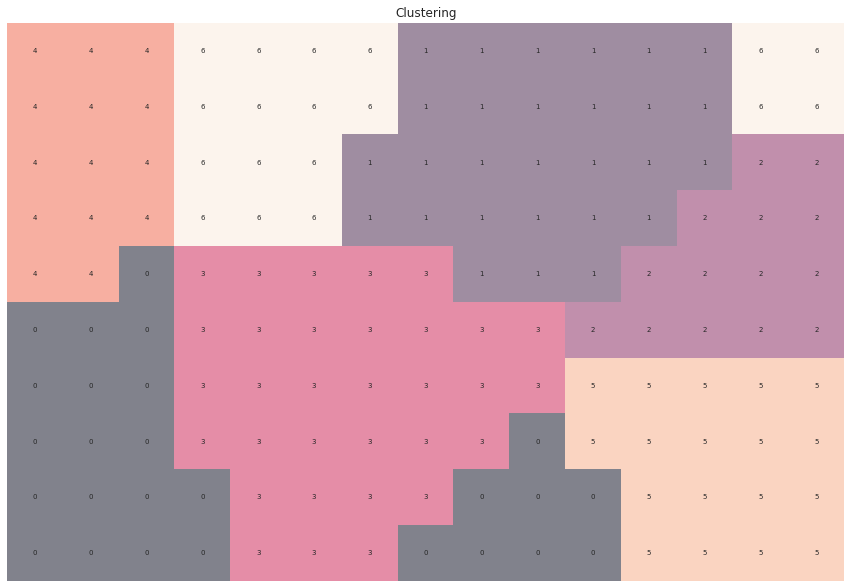

In [527]:
from sompy.visualization.hitmap import HitMapView

k_val = 7
sm.cluster(k_val)
hits  = HitMapView(15, 15, "Clustering", text_size=14)
a     = hits.show(sm)
plt.savefig(os.path.join(o_dir,f"{c_nm}-Hit Map View.png"), dpi=200)

#### Clustering the BMUs

<img src="https://github.com/kingsgeocomp/applied_gsa/raw/master/img/som_clusters.png" alt="SOM Clustering Results" width="400" />

How many data points were assigned to each BMU?

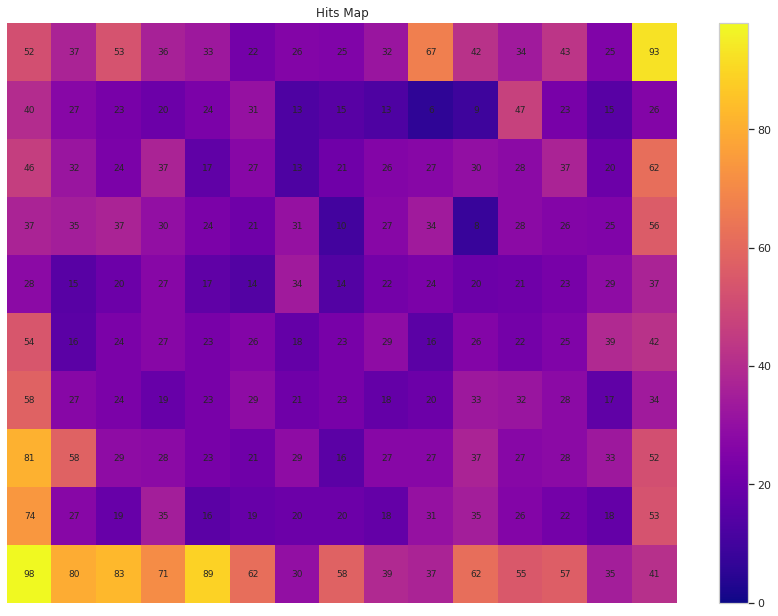

In [528]:
from sompy.visualization.bmuhits import BmuHitsView
vhts = BmuHitsView(15, 15, "Hits Map", text_size=8)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=9, cmap="plasma", logaritmic=False)
plt.savefig(os.path.join(o_dir,f"{c_nm}-BMU Hit View.png"), dpi=200)

#### BMU Hit Map

<img src="https://github.com/kingsgeocomp/applied_gsa/raw/master/img/som_heat.png" alt="SOM Heat Map Results" width="750" />

Finally, let's get the cluster results and map them back on to the data points:

In [534]:
cldf.drop('SOM',inplace=True,axis=1)

KeyError: "['SOM'] not found in axis"

In [535]:
# Get the labels for each BMU
# in the SOM (15 * 10 neurons)
clabs = sm.cluster_labels

try:
    cldf.drop(c_nm,inplace=True,axis=1)
except KeyError:
    pass

# Project the data on to the SOM
# so that we get the BMU for each
# of the original data points
bmus  = sm.project_data(cldf.values)

# Turn the BMUs into cluster labels
# and append to the data frame
s = pd.Series(clabs[bmus], index=cldf.index, name=c_nm)

cldf[c_nm] = s
result_set = add_2_rs(s)

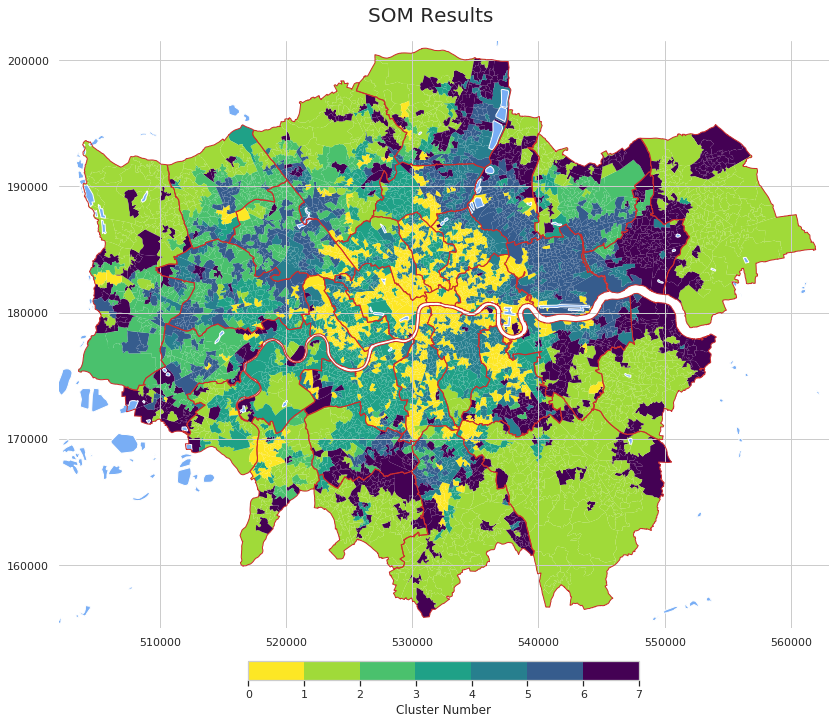

In [537]:
cgdf = gdf.join(cldf, how='inner')

breaks = np.arange(cldf[c_nm].min(),cldf[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks))
norm   = mpl.colors.BoundaryNorm(breaks, cmap.N, clip=False)

fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)

cgdf.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0, legend=False)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks)

plt.savefig(os.path.join(o_dir,f"{c_nm}.png"), dpi=200)
del(cgdf)

#### Result!

<img src="https://github.com/kingsgeocomp/applied_gsa/raw/master/img/som_cluster_map.png" alt="SOM Clustering Results Mapped" width="600" />

## Wrap-Up

You've reached the end, you're done... 

Er, no. This is barely scratching the surface! I'd suggest that you go back through the above code and do three things:
1. Add a lot more comments to the code to ensure that really have understood what is going on.
2. Try playing with some of the parameters (e.g. my thresholds for skew, or non-normality) and seeing how your results change.
3. Try outputting additional plots that will help you to understand the _quality_ of your clustering results (e.g. what _is_ the makeup of cluster 1? Or 6? What has it picked up? What names would I give these clsuters?).

If all of that seems like a lot of work then why not learn a bit more about machine learning before calling it a day?

See: [Introduction to Machine Learning with Scikit-Learn](http://www.slideshare.net/BenjaminBengfort/introduction-to-machine-learning-with-scikitlearn).